# <font color='red'> Project 2

Project Description:
- Use same datasets as Project 1.
- Preprocess data: Explore data and apply data scaling.

Regression Task:
- Apply any two models with bagging and any two models with pasting.
- Apply any two models with adaboost boosting
- Apply one model with gradient boosting
- Apply PCA on data and then apply all the models in project 1 again on data you get from PCA. Compare your results with results in project 2. You don't need to apply all the models twice. Just copy the result table from project 1, prepare similar table for all the models after PCA and compare both tables. Does PCA help in getting better results?
- Apply deep learning models covered in class

Classification Task:
- Apply two voting classifiers - one with hard voting and one with soft voting
- Apply any two models with bagging and any two models with pasting.
- Apply any two models with adaboost boosting
- Apply one model with gradient boosting
- Apply PCA on data and then apply all the models in project 1 again on data you get from PCA. Compare your results with results in project 1. You don't need to apply all the models twice. Just copy the result table from project 1, prepare similar table for all the models after PCA and compare both tables. Does PCA help in getting better results?
- Apply deep learning models covered in class

Deliverables:
- Use markdown to provide inline comments for this project.
- Your outputs should be clearly executed in the notebook i.e. we should not need to rerun the code to obtain the outputs.
- Visualization encouraged.
- If you are submitting two different files, then please only one group member submit both the files. If you submit two files separately from different accounts, it will be submitted as two different attempts.
- If you are submitting two different files, then please follow below naming convetion:
    Project2_Regression_GroupXX_Firstname1_Firstname2.ipynb
    Project2_Classification_GroupXX_Firstname1_Firstname2.ipynb
- If you are submitting single file, then please follow below naming convetion:
    Project2_Both_GroupXX_Firstname1_Firstname2.ipynb

Questions regarding the project:
- We have created a discussion board under Projects folder on e-learning. Create threads over there and post your queries related to project there.
- We will also answer queries there. We will not be answering any project related queries through the mail.

# Housing Data Regression Modeling

Link for the dataset:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques

Lets import all required libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.linear_model import Lasso, Ridge, LinearRegression, SGDRegressor
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA

Set option to display all columns in the notebook while displaying dataframe

In [3]:
pd.set_option('display.max_columns', None)

Import the dataset.

In [4]:
df = pd.read_csv("train.csv")

We have 81 features with 1460 records overall.

In [5]:
df.shape

(1460, 81)

We have a good combination of numerical, ordinal, and categorical features. We also have quite a few missing values around 6%.

In [6]:
print("Percentage missing values across the dataset: %5.4f" % (df.isna().mean().mean()*100),"%", sep='')

Percentage missing values across the dataset: 5.8896%


# Descriptive statistics summary for 'SalePrice', that is, Target Variable

In [7]:
df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

# Histogram for the target variable

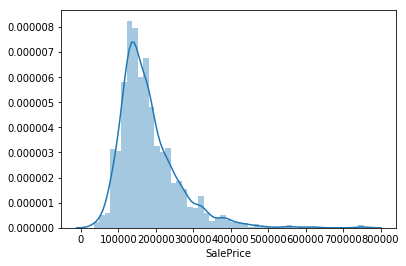

In [8]:
sns.distplot(df['SalePrice']);

It is clear from the above histogram that SalePrice deviate from the normal distribution and have appreciable positive skewness with a peak

# Skewness and Kurtosis

Here are some body measures for our SalePrice

In [9]:
print("Skewness: %f" % df['SalePrice'].skew())
print("Kurtosis: %f" % df['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


# Relationship with numerical variables

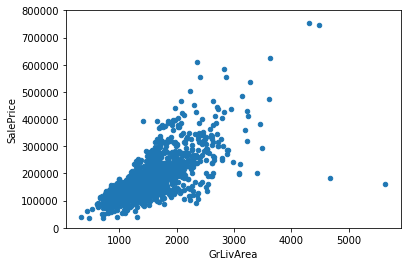

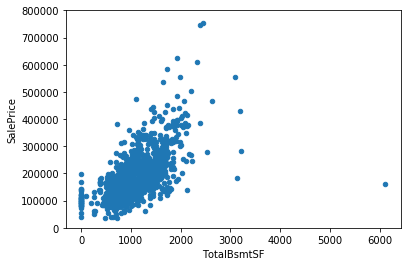

In [10]:
#scatter plot grlivarea/saleprice
var = 'GrLivArea'
data = pd.concat([df['SalePrice'], df[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

#scatter plot totalbsmtsf/saleprice
var = 'TotalBsmtSF'
data = pd.concat([df['SalePrice'], df[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

It seems that SalePrice and GrLivArea has a very good linear relationship however relationship between SalePrice and
TotalBsmtSF is a distorted linear relationship

# Relationship with categorical variables

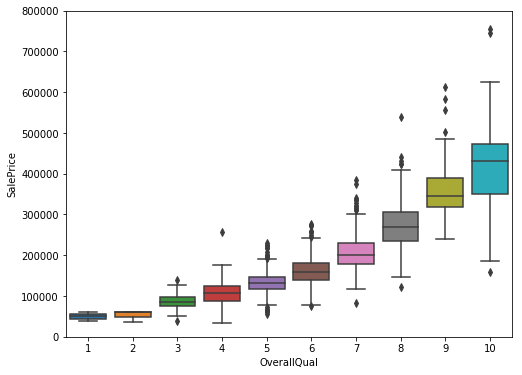

In [11]:
#box plot of overallqual and saleprice

var = 'OverallQual'
data = pd.concat([df['SalePrice'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

Here we can see that the average SalePrice is increasing as the OverallQual is increasing

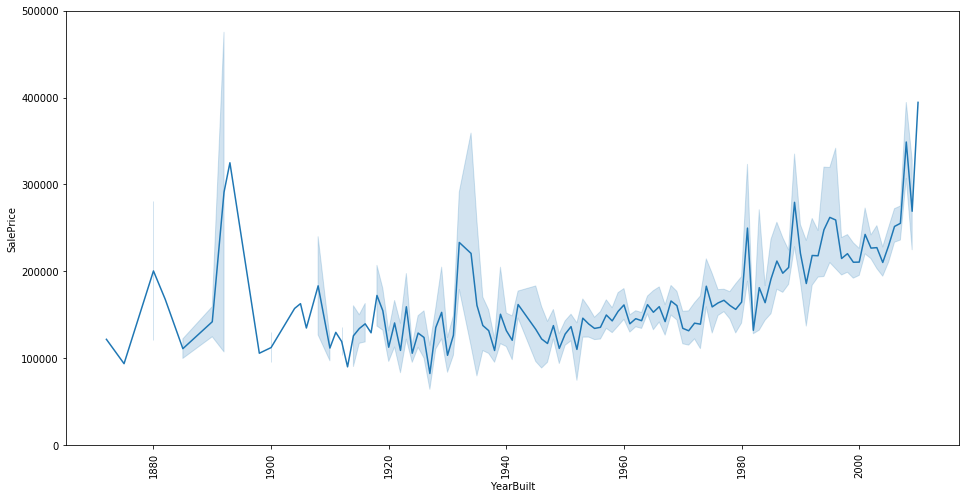

In [12]:
var = 'YearBuilt'
data = pd.concat([df['SalePrice'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.lineplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=500000);
plt.xticks(rotation=90);

Although the graph here is showing non-uniform results however, we can say that 'SalePrice' is higher in early 90's and
2000 but less in the older times. Also, this result tends to change as we normalize our data.

Here, we just analyzed 4 features as they tend to show significant relationship and proved to be after plotting. 
Using the data dictionary we decided to show the relationship between these variables.

To explore more, we will be heading to see what the correlation matrix shows where the air can be cleared!

# CORRELATION PLOT

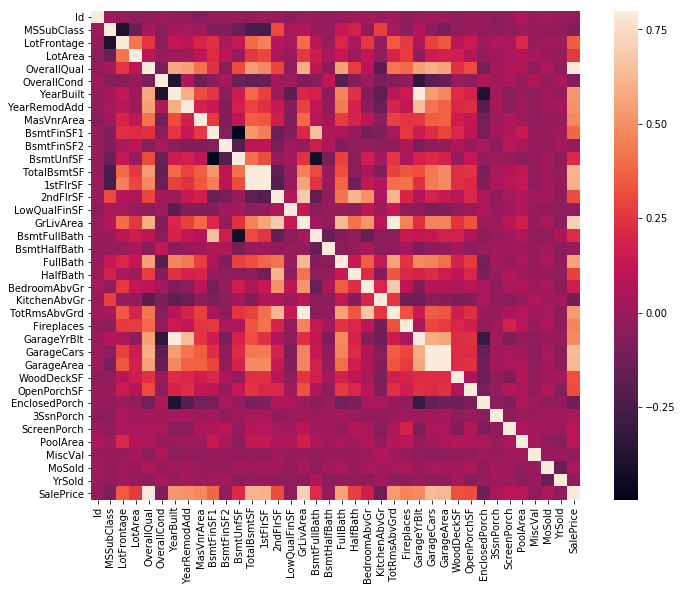

In [13]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

Here we can see that there is a strong correlation between 'TotalBsmtSF' and '1stFlrSF' variables and 'GarageYrBlt',
'GarageCars' and 'GarageArea' are also having very strong relationship among themselves.This shows that there is a 
multicollinearity problem occuring in the data which we can resolve as we step up!

# 'SalePrice' Correlation Matrix with some features

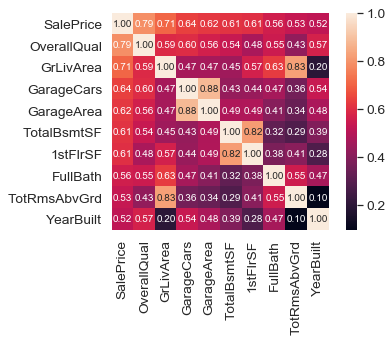

In [14]:
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

We can see that'OverallQual', 'GrLivArea' and 'TotalBsmtSF' are strongly correlated with 'SalePrice'.
Also, here we can see that 'YearBuilt' has not that much correlation with 'SalePrice'. Hence, heatmap is a great way to see exact correlations happening in the data

# Scatter Plots of highly correlated variables

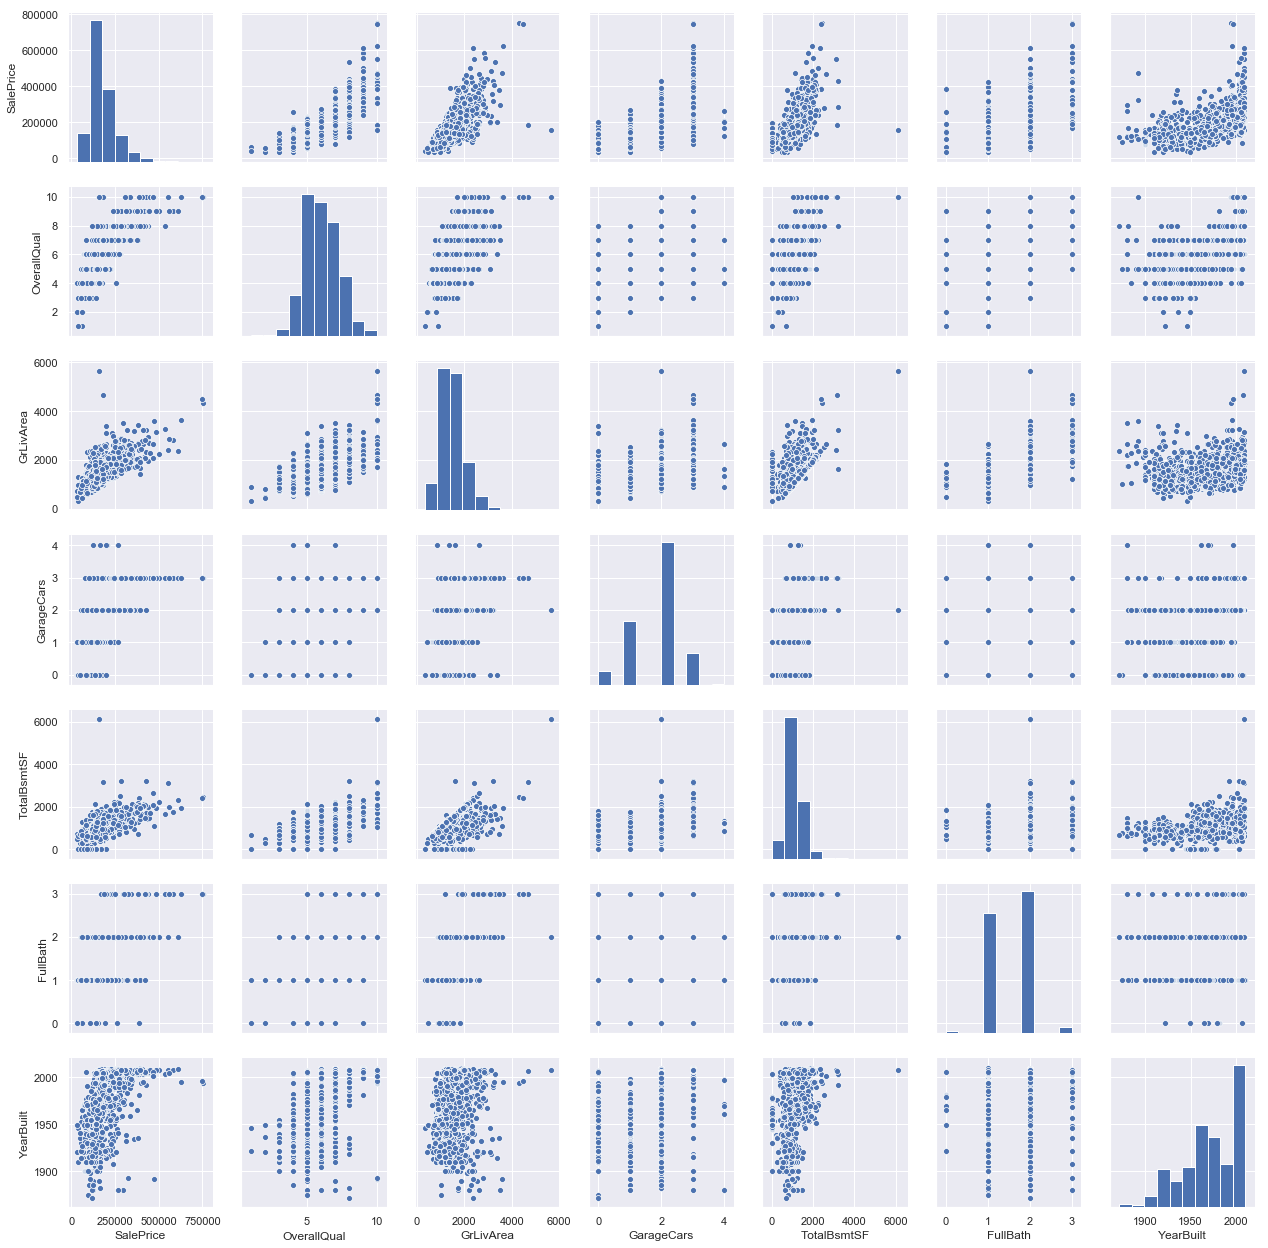

In [15]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df[cols], size = 2.5)
plt.show();

Here, the relationship between 'TotalBsmtSF' and 'GrLiveArea' is giving us really informative and logical insight about
the data as we can see the dots drawing a linear line which almost acts like a border. It totally makes sense that the
majority of the dots stay below that line. Basement areas can be equal to the above ground living area, but it is not
expected a basement area bigger than the above ground living area in the real world

# Plotting Histogram for Continous Variables

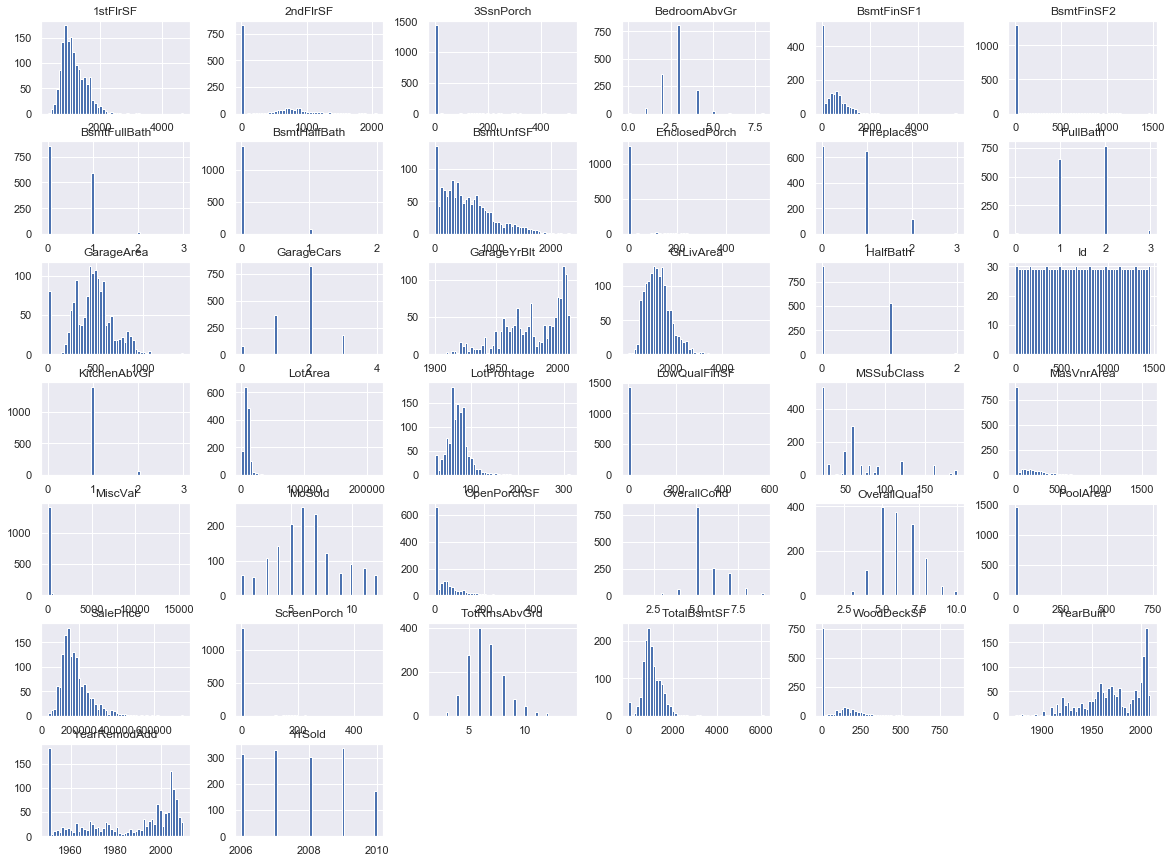

In [16]:
df.hist(bins=50, figsize=(20,15))
plt.show()

We can see that there is skewness in some continuous variables and some features have mostly one value.

# Let us see what our target variable on histogram looks like

Text(0.5, 1.0, 'SalePrice')

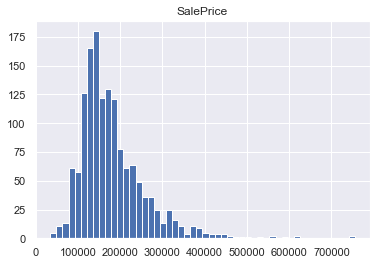

In [17]:
df['SalePrice'].hist(bins=50)
plt.title("SalePrice")

# Lets drop all clearly insignificant data with respect to machine learning model.

In [18]:
df.drop(columns = ["Id"], inplace = True)

Lets create house age as YearSold - YearBuilt. House age will play key role in deciding the selling price of the house.

In [19]:
df["HouseAge"] = df["YrSold"] - df["YearBuilt"]

Lets create garage age as YearSold - GarageYrBlt. Garage age will play key role in deciding the selling price of the house.

In [20]:
df["GarageAge"] = df["YrSold"] - df["GarageYrBlt"]

And then drop YearSold, YearBuilt, MoSold & GarageYrBlt column to avoid co-linearity in the model

In [21]:
df.drop(columns=["YrSold", "YearBuilt", "MoSold", "GarageYrBlt"], inplace = True)

In  total we have 4 fields for number of bathrooms. They are BsmtFullBath, BsmtHalfBath, FullBath & HalfBath. We can sum them up to get the information of 4 features in one. Baths_total =  BsmtFullBath + FullBath + 0.5 * BsmtHalfBath + 0.5 * HalfBath

In [22]:
df["Baths_total"] = df["BsmtFullBath"] + df["FullBath"] + (0.5 * df["BsmtHalfBath"]) + (0.5 * df["HalfBath"])

And then drop BsmtFullBath, BsmtHalfBath, FullBath & HalfBath columns to avoid co-linearity in the model

In [23]:
df.drop(columns=["BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath"], inplace = True)

In total we have 7 fields for Square footage of the house. They are TotalBsmtSF, 1stFlrSF, 2ndFlrSF, GrLivArea, GarageArea, LotArea & PoolArea. We can find out FloorArea (which is total area inside house) as combination 3 features. <br /> 
FloorArea = TotalBsmtSF + 1stFlrSF + 2ndFlrSF.<br />
GrLivArea is nothing but 1stFlrSF + 2ndFlrSF. So we can straightaway drop GrLivArea. <br />
There are three more fields for square footage which are GarageArea, LotArea and PoolArea but we will not add them in FloorArea as their area will decide final sale price and they will play individual roles in machine learning models.

In [24]:
df["FloorArea"] = df["TotalBsmtSF"] + df["1stFlrSF"] + df["2ndFlrSF"]

And then drop "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "GrLivArea" columns to avoid co-linearity in the model

In [25]:
df.drop(columns=["TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "GrLivArea"], inplace = True)

Lets remove skewness from all continous variables in dataset

In [26]:
from scipy.stats import skew
categorical_features = df.select_dtypes(include = ["object"]).columns
numerical_features = df.select_dtypes(exclude = ["object"]).columns
#numerical_features = numerical_features.drop("SalePrice")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
train_num = df[numerical_features]
train_cat = df[categorical_features]

Numerical features : 29
Categorical features : 43


### Important : If you log transform the response variable, it is required to also log transform feature variables that are skewed.

In [27]:
# Log transform of the skewed numerical features to lessen impact of outliers
# Inspired by Alexandru Papiu's script : https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed
skewness = train_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
train_num[skewed_features] = np.log1p(train_num[skewed_features])

21 skewed numerical features to log transform


In [28]:
# Join categorical and numerical features
df = pd.concat([train_num, train_cat], axis = 1)

Dropping outliers from all features using z-score

In [29]:
# identify outliers with standard deviation
from numpy import mean
from numpy import std
for column in df.columns.tolist():
    if df[column].dtype != object:
        # calculate summary statistics
        data_mean, data_std = mean(df[column]), std(df[column])
        # identify outliers
        cut_off = data_std * 3
        lower, upper = data_mean - cut_off, data_mean + cut_off
        # identify outliers
        outliers = [x for x in df[column] if x < lower or x > upper]
        print('Identified outliers for %s: %d' % (column, len(outliers)))
        # remove outliers
        outliers_removed = [x for x in df[column] if x >= lower and x <= upper]
        print('Non-outlier observations for %s: %d' % (column, len(outliers_removed)))
        
        df = df[(df[column] > lower) & (df[column] < upper)]

Identified outliers for MSSubClass: 0
Non-outlier observations for MSSubClass: 1460
Identified outliers for LotFrontage: 12
Non-outlier observations for LotFrontage: 1189
Identified outliers for LotArea: 33
Non-outlier observations for LotArea: 1156
Identified outliers for OverallQual: 1
Non-outlier observations for OverallQual: 1155
Identified outliers for OverallCond: 5
Non-outlier observations for OverallCond: 1150
Identified outliers for YearRemodAdd: 0
Non-outlier observations for YearRemodAdd: 1150
Identified outliers for MasVnrArea: 27
Non-outlier observations for MasVnrArea: 1117
Identified outliers for BsmtFinSF1: 0
Non-outlier observations for BsmtFinSF1: 1117
Identified outliers for BsmtFinSF2: 53
Non-outlier observations for BsmtFinSF2: 1064
Identified outliers for BsmtUnfSF: 74
Non-outlier observations for BsmtUnfSF: 990
Identified outliers for LowQualFinSF: 19
Non-outlier observations for LowQualFinSF: 971
Identified outliers for BedroomAbvGr: 6
Non-outlier observations f

Lets drop all those columns which have more than 90% of the same data

In [30]:
lst_columns = []
for column in df.columns:
    series = (df[column].value_counts() > (sum(df[column].value_counts()) * 0.90))
    if series.any():
        print(column," : "," has value '",series[series == True].index[0],"' greater than 90% of the times.",sep='')
        lst_columns.append(column)

BsmtFinSF2 :  has value '0.0' greater than 90% of the times.
LowQualFinSF :  has value '0.0' greater than 90% of the times.
KitchenAbvGr :  has value '0.6931471805599453' greater than 90% of the times.
3SsnPorch :  has value '0.0' greater than 90% of the times.
ScreenPorch :  has value '0.0' greater than 90% of the times.
PoolArea :  has value '0.0' greater than 90% of the times.
MiscVal :  has value '0.0' greater than 90% of the times.
Street :  has value 'Pave' greater than 90% of the times.
LandContour :  has value 'Lvl' greater than 90% of the times.
Utilities :  has value 'AllPub' greater than 90% of the times.
LandSlope :  has value 'Gtl' greater than 90% of the times.
Condition2 :  has value 'Norm' greater than 90% of the times.
RoofMatl :  has value 'CompShg' greater than 90% of the times.
BsmtCond :  has value 'TA' greater than 90% of the times.
BsmtFinType2 :  has value 'Unf' greater than 90% of the times.
Heating :  has value 'GasA' greater than 90% of the times.
CentralAir 

In [31]:
df.drop(columns = lst_columns, inplace = True)

In [32]:
df.shape

(769, 49)

# Checking the categorical columns that have NA values and impute them accordingly.

In [33]:
lst_categorical_columns = []
for column in df.columns:
    if df[column].dtype == object and np.nan in df[column].unique().tolist():
        print(column,":",df[column].unique())
        lst_categorical_columns.append(column)

Alley : [nan 'Grvl' 'Pave']
BsmtExposure : ['No' 'Gd' 'Mn' 'Av' nan]
FireplaceQu : [nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']
PoolQC : [nan]
Fence : [nan 'GdPrv' 'MnPrv' 'GdWo' 'MnWw']


We can see that categorical columns Alley, FireplaceQu, PoolQC, Fence & MiscFeature have nan values.<br />
For Alley column NaN means No alley access. So here we can impute NaN with new category No alley access.<br />
For FireplaceQu column NaN is No Fireplace. So here we can impute NaN with new category No Fireplace.<br />
For PoolQC column NaN is No Pool. So here we can impute NaN with new category No Pool.<br />
For Fence column NaN is No Fence. So here we can impute NaN with new category No Fence.<br />
For MiscFeature column NaN means No features like Elevator, tennis court, shed etc. So here we can impute NaN with new category No MiscFeature.<br />
For Utilities column we don't know what NaN means. So here since its a categorical column we can impute NaN with mode value.<br />

In [34]:
df.Alley.replace(np.nan,"No Alley Access", inplace = True)
df.Alley.unique()

array(['No Alley Access', 'Grvl', 'Pave'], dtype=object)

In [35]:
df.FireplaceQu.replace(np.nan,"No Fireplace", inplace = True)
df.FireplaceQu.unique()

array(['No Fireplace', 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

Lets do label encoding on the FirePlaceQu column as it is clearly an ordinal field with below meanings - <br />
Ex   Excellent - Exceptional Masonry Fireplace<br />
Gd   Good - Masonry Fireplace in main level<br />
TA   Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement<br />
Fa   Fair - Prefabricated Fireplace in basement<br />
Po   Poor - Ben Franklin Stove<br />
NA   No Fireplace

In [36]:
df.FireplaceQu = df.FireplaceQu.map({'No Fireplace':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})
df.FireplaceQu.unique()

array([0, 3, 4, 2, 5, 1], dtype=int64)

In [37]:
df.PoolQC.replace(np.nan,"No Pool", inplace = True)
df.PoolQC.unique()

array(['No Pool'], dtype=object)

In [38]:
df.PoolQC = df.PoolQC.map({'No Pool':0, 'Fa': 1, 'Gd': 2, 'Ex': 3})
df.PoolQC.unique()

array([0], dtype=int64)

In [39]:
df.Fence.replace(np.nan,"No Fence", inplace = True)
df.Fence.unique()

array(['No Fence', 'GdPrv', 'MnPrv', 'GdWo', 'MnWw'], dtype=object)

In [40]:
df.BsmtExposure.replace(np.nan, "No Basement", inplace = True)
df.BsmtExposure.unique()

array(['No', 'Gd', 'Mn', 'Av', 'No Basement'], dtype=object)

Refers to walkout or garden level walls - <br />
  Gd   Good Exposure<br />
   Av   Average Exposure (split levels or foyers typically score average or above)<br />
   Mn   Mimimum Exposure<br />
   No   No Exposure<br />
   NA   No Basement<br />


In [41]:
df.BsmtExposure = df.BsmtExposure.map({'No Basement':0, 'No':1, 'Mn': 2, 'Av':3, 'Gd': 4})
df.BsmtExposure.unique()

array([1, 4, 2, 3, 0], dtype=int64)

In [42]:
df.BsmtFinType1.replace(np.nan, "No Basement", inplace = True)
df.BsmtFinType1.unique()

array(['GLQ', 'ALQ', 'Rec', 'Unf', 'LwQ', 'BLQ'], dtype=object)

Rating of basement finished area - <br />
  GLQ  Good Living Quarters<br />
   ALQ  Average Living Quarters<br />
   BLQ  Below Average Living Quarters<br />   
   Rec  Average Rec Room<br />
   LwQ  Low Quality<br />
   Unf  Unfinshed<br />
   NA   No Basement<br />


In [43]:
df.BsmtFinType1 = df.BsmtFinType1.map({'No Basement':0, 'Unf':1, 'LwQ': 2, 'Rec':3, 'BLQ': 4, 'ALQ':5, 'GLQ':6})
df.BsmtFinType1.unique()

array([6, 5, 3, 1, 2, 4], dtype=int64)

Rating of basement finished area (if multiple types) -<br />
  GLQ  Good Living Quarters<br />
   ALQ  Average Living Quarters<br />
   BLQ  Below Average Living Quarters<br />   
   Rec  Average Rec Room<br />
   LwQ  Low Quality<br />
   Unf  Unfinshed<br />
   NA   No Basement<br />


In [44]:
df.BsmtQual.replace(np.nan, "No Basement", inplace = True)
df.BsmtQual.unique()

array(['Gd', 'TA', 'Ex', 'Fa'], dtype=object)

In [45]:
df.BsmtQual = df.BsmtQual.map({'No Basement':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4})
df.BsmtQual.unique()

array([3, 2, 4, 1], dtype=int64)

In [46]:
df.Exterior1st.replace(np.nan, df.Exterior1st.mode()[0], inplace = True)
df.Exterior1st.unique()

array(['VinylSd', 'MetalSd', 'Wd Sdng', 'HdBoard', 'WdShing', 'BrkFace',
       'CemntBd', 'Stucco', 'Plywood', 'AsbShng', 'BrkComm', 'ImStucc',
       'CBlock'], dtype=object)

In [47]:
df.Exterior2nd.replace(np.nan, df.Exterior2nd.mode()[0], inplace = True)
df.Exterior2nd.unique()

array(['VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Wd Sdng', 'Plywood',
       'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'Brk Cmn', 'ImStucc',
       'AsphShn', 'Stone', 'CBlock'], dtype=object)

In [48]:
df.GarageFinish.replace(np.nan, "No Garage", inplace = True)
df.GarageFinish.unique()

array(['RFn', 'Unf', 'Fin'], dtype=object)

Interior finish of the garage - <br />
  Fin-  Finished<br />
   RFn-  Rough Finished<br />  
   Unf-  Unfinished<br />
   NA-   No Garage<br />

In [49]:
df.GarageFinish = df.GarageFinish.map({'No Garage':0, 'Unf': 1, 'RFn': 2, 'Fin': 3})
df.GarageFinish.unique()

array([2, 1, 3], dtype=int64)

In [50]:
df.GarageType.replace(np.nan, "No Garage", inplace = True)
df.GarageType.unique()

array(['Attchd', 'Detchd', 'BuiltIn', 'CarPort', 'Basment'], dtype=object)

In [51]:
df.KitchenQual.replace(np.nan, "TA", inplace = True)
df.KitchenQual.unique()

array(['Gd', 'TA', 'Ex', 'Fa'], dtype=object)

In [52]:
df.KitchenQual = df.KitchenQual.map({'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4})
df.KitchenQual.unique()

array([3, 2, 4, 1], dtype=int64)

In [53]:
df.MSZoning.replace(np.nan, df.MSZoning.mode()[0], inplace = True)
df.MSZoning.unique()

array(['RL', 'RM', 'FV', 'RH', 'C (all)'], dtype=object)

In [54]:
df.MasVnrType.replace(np.nan, df.MasVnrType.mode()[0], inplace = True)
df.MasVnrType.unique()

array(['BrkFace', 'None', 'Stone', 'BrkCmn'], dtype=object)

In [55]:
df.SaleType.replace(np.nan, df.SaleType.mode()[0], inplace = True)
df.SaleType.unique()

array(['WD', 'New', 'COD', 'ConLw', 'Con', 'ConLI', 'CWD', 'ConLD', 'Oth'],
      dtype=object)

# Additionally we have 3 more features where we can do label encoding

In [56]:
df.ExterCond = df.ExterCond.map({'Po':1, 'Fa': 2, 'TA': 3, 'Gd':4, 'Ex': 5})
df.ExterCond.unique()

array([3, 4, 2, 5], dtype=int64)

In [57]:
df.ExterQual = df.ExterQual.map({'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4})
df.ExterQual.unique()

array([3, 2, 4, 1], dtype=int64)

In [58]:
df.HeatingQC = df.HeatingQC.map({'Po':1, 'Fa': 2, 'TA': 3, 'Gd':4, 'Ex': 5})
df.HeatingQC.unique()

array([5, 4, 3, 2, 1], dtype=int64)

# Lets fill up NaNs in remaining continuous columns with median of respective columns

In [59]:
features = df.columns.tolist()
features.remove("SalePrice")

In [60]:
df = df.fillna(df[features].median())

In [61]:
df.isna().sum().sum()

0

In [62]:
df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,SalePrice,HouseAge,GarageAge,Baths_total,FloorArea,MSZoning,Alley,LotShape,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,HeatingQC,KitchenQual,FireplaceQu,GarageType,GarageFinish,PoolQC,Fence,SaleType,SaleCondition
0,4.110874,65.0,9.042040,7,1.791759,7.602900,196.0,6.561031,5.017280,3,2.197225,0.000000,2,548,0.000000,4.127134,0.000000,12.247699,1.791759,5.0,3.5,7.850493,RL,No Alley Access,Reg,Inside,CollgCr,Norm,1Fam,2Story,Gable,VinylSd,VinylSd,BrkFace,3,3,PConc,3,1,6,5,3,0,Attchd,2,0,No Fence,WD,Normal
1,3.044522,80.0,9.169623,6,2.197225,7.589336,0.0,6.886532,5.652489,3,1.945910,0.693147,2,460,5.700444,0.000000,0.000000,12.109016,3.465736,31.0,2.5,7.833996,RL,No Alley Access,Reg,FR2,Veenker,Feedr,1Fam,1Story,Gable,MetalSd,MetalSd,None,2,3,CBlock,3,4,5,5,2,3,Attchd,2,0,No Fence,WD,Normal
2,4.110874,68.0,9.328212,7,1.791759,7.602401,162.0,6.188264,6.075346,3,1.945910,0.693147,2,608,0.000000,3.761200,0.000000,12.317171,2.079442,7.0,3.5,7.903596,RL,No Alley Access,IR1,Inside,CollgCr,Norm,1Fam,2Story,Gable,VinylSd,VinylSd,BrkFace,3,3,PConc,3,2,6,5,3,3,Attchd,2,0,No Fence,WD,Normal
3,4.262680,60.0,9.164401,7,1.791759,7.586296,0.0,5.379897,6.293419,3,2.079442,0.693147,3,642,0.000000,3.583519,5.609472,11.849405,4.521789,8.0,2.0,7.813592,RL,No Alley Access,IR1,Corner,Crawfor,Norm,1Fam,2Story,Gable,Wd Sdng,Wd Shng,None,2,3,BrkTil,2,1,5,4,3,4,Detchd,1,0,No Fence,WD,Abnorml
4,4.110874,84.0,9.565284,8,1.791759,7.601402,350.0,6.486161,6.196444,4,2.302585,0.693147,3,836,5.262690,4.442651,0.000000,12.429220,2.197225,8.0,3.5,8.114923,RL,No Alley Access,IR1,FR2,NoRidge,Norm,1Fam,2Story,Gable,VinylSd,VinylSd,BrkFace,3,3,PConc,3,3,6,5,3,3,Attchd,2,0,No Fence,WD,Normal


In [63]:
df.shape

(769, 49)

# To finalizing the dataset for running the models we have to remove highly correlated features.

In [64]:
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
df.drop(columns = to_drop, axis=1, inplace = True)

In [65]:
df.shape # Since no columns were dropped which means there are no correalated features present in our dataset

(769, 49)

# Performing one hot encoding for all remaining nominal variables

In [66]:
df = pd.get_dummies(df, drop_first=True)

In [67]:
df.shape

(769, 143)

# Setting the target and features seperately

In [68]:
features = df.columns.tolist()
features.remove("SalePrice")
target = "SalePrice"

Most of the times, your dataset will contain features highly varying in magnitudes, units and range. But since, most of the machine learning algorithms use Eucledian distance between two data points in their computations, this is a problem.
<br />
<br />
Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data which is the case in our dataset as seen in histograms plotted earlier.
<br />
<br />
We are choosing MinMaxScaler() rather than StandardScaler() because:
    - It deals with the outliers in the data better than StandardScaler()
    - It will reserve the natural variation of the feature unlike any other scaling functions

In [69]:
# Now creating X by removing target column
X = df[features].copy()
y = df[target].copy()

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X = pd.DataFrame(X, index=df[features].index, columns=df[features].columns)

In [70]:
report_df = pd.DataFrame(columns=["Regressor", "Avg Train Score", "Avg Test Score", "Avg Train RMSE", "Avg Test RMSE", "Best Hyperparameters"])
new_report_df = pd.DataFrame(columns=["Regressor", "Avg Train Score", "Avg Test Score", "Avg Train RMSE", "Avg Test RMSE", "Best Hyperparameters"])
pca_report_df = pd.DataFrame(columns=["Regressor", "Avg Train Score", "Avg Test Score", "Avg Train RMSE", "Avg Test RMSE", "Best Hyperparameters"])
nn_report_df = pd.DataFrame(columns=["Regressor", "Avg Train Score", "Avg Test Score", "Avg Train RMSE", "Avg Test RMSE", "Best Hyperparameters"])

# Lasso

In [71]:
parameters = [{'alpha':[0.001,0.01,0.1,1,10,100]}]

grid_search = GridSearchCV(estimator = Lasso(), param_grid = parameters, cv=KFold(3, random_state = 0), n_jobs = -1, return_train_score=True)

grid_search = grid_search.fit(X,y)

print("Grid search best Score:", grid_search.best_score_)
print("Grid search best parameters:", grid_search.best_params_)

Grid search best Score: 0.905121497782466
Grid search best parameters: {'alpha': 0.001}


In [72]:
regressor_name = "Lasso"

train_score_list = []
test_score_list = []
train_rmse_score_list = []
test_rmse_score_list = []

avg_train_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_train_score']
avg_test_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_test_score']

train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_train_score'])

test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_test_score'])

for train, test in grid_search.cv.split(X):
    train_rmse_score_list.append(np.sqrt(mean_squared_error(y.iloc[train], grid_search.best_estimator_.predict(X.iloc[train]))))
    test_rmse_score_list.append(np.sqrt(mean_squared_error(y.iloc[test], grid_search.best_estimator_.predict(X.iloc[test]))))

print("3 Fold Train score for",regressor_name,":", train_score_list)
print("3 Fold Test score for",regressor_name,":", test_score_list)
print()
print("Average training score for",regressor_name,"using cross validation:", avg_train_score)
print("Average testing score for",regressor_name,"using cross validation:", avg_test_score)
print()
print("Average training RMSE for",regressor_name,"using cross validation:", sum(train_rmse_score_list) / 3)
print("Average testing RMSE for",regressor_name,"using cross validation:", sum(test_rmse_score_list) / 3)

report_df = report_df.append({"Regressor":regressor_name, "Avg Train Score":avg_train_score, 
                              "Avg Test Score":avg_test_score, "Avg Train RMSE":sum(train_rmse_score_list) / 3,
                              "Avg Test RMSE":sum(test_rmse_score_list) / 3,
                              "Best Hyperparameters" : grid_search.best_params_}, ignore_index=True)

3 Fold Train score for Lasso : [0.9208066227711649, 0.9303945696076439, 0.9327308271447579]
3 Fold Test score for Lasso : [0.9223348336926199, 0.8994473399350283, 0.8935150801263504]

Average training score for Lasso using cross validation: 0.9279773398411889
Average testing score for Lasso using cross validation: 0.905121497782466

Average training RMSE for Lasso using cross validation: 0.09887536236281876
Average testing RMSE for Lasso using cross validation: 0.0987822860311094


# Lasso with AdaBoost boosting

In [74]:
param_grid = {"learning_rate": [0.01, 0.1, 0.5, 1],
              "loss": ["linear", "square", "exponential"]}

grid_search = GridSearchCV(estimator = AdaBoostRegressor(grid_search.best_estimator_), param_grid = param_grid, cv=KFold(3, random_state = 0), n_jobs = -1, return_train_score=True)

grid_search = grid_search.fit(X,y)

print("Grid search best Score for",regressor_name,"with AdaBoosting:", grid_search.best_score_)
print("Grid search best parameters:", grid_search.best_params_)

Grid search best Score for Lasso with AdaBoosting: 0.9058221988122281
Grid search best parameters: {'learning_rate': 0.01, 'loss': 'exponential'}


In [75]:
regressor_name = "Lasso with Adaboosting"

train_score_list = []
test_score_list = []
train_rmse_score_list = []
test_rmse_score_list = []

avg_train_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_train_score']
avg_test_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_test_score']

train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_train_score'])

test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_test_score'])

for train, test in grid_search.cv.split(X):
    train_rmse_score_list.append(np.sqrt(mean_squared_error(df[target].iloc[train], grid_search.best_estimator_.predict(df[features].iloc[train]))))
    test_rmse_score_list.append(np.sqrt(mean_squared_error(df[target].iloc[test], grid_search.best_estimator_.predict(df[features].iloc[test]))))

print("3 Fold Train score for",regressor_name,":", train_score_list)
print("3 Fold Test score for",regressor_name,":", test_score_list)
print()
print("Average training score for",regressor_name,"using cross validation:", avg_train_score)
print("Average testing score for",regressor_name,"using cross validation:", avg_test_score)
print()
print("Average training RMSE for",regressor_name,"using cross validation:", sum(train_rmse_score_list) / 3)
print("Average testing RMSE for",regressor_name,"using cross validation:", sum(test_rmse_score_list) / 3)

new_report_df = new_report_df.append({"Regressor":regressor_name, "Avg Train Score":avg_train_score, 
                              "Avg Test Score":avg_test_score, "Avg Train RMSE":sum(train_rmse_score_list) / 3,
                              "Avg Test RMSE":sum(test_rmse_score_list) / 3,
                              "Best Hyperparameters" : grid_search.best_params_}, ignore_index=True)

3 Fold Train score for Lasso with Adaboosting : [0.9248729357297933, 0.9341519681423959, 0.9356091305734822]
3 Fold Test score for Lasso with Adaboosting : [0.921475805000961, 0.8995475080102516, 0.8963821365262967]

Average training score for Lasso with Adaboosting using cross validation: 0.9315446781485571
Average testing score for Lasso with Adaboosting using cross validation: 0.9058221988122281

Average training RMSE for Lasso with Adaboosting using cross validation: 47.47144113995807
Average testing RMSE for Lasso with Adaboosting using cross validation: 47.47038468884318


Text(0, 0.5, 'Lasso Score')

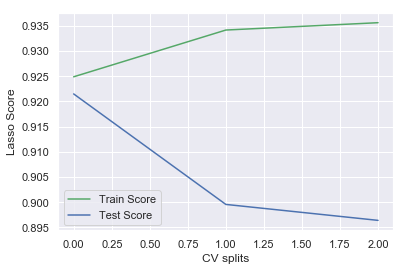

In [76]:
plt.plot(train_score_list, c = 'g', label = 'Train Score')
plt.plot(test_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel('Lasso Score')

Text(0, 0.5, 'Lasso RMSE')

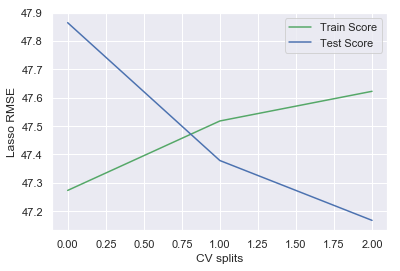

In [77]:
plt.plot(train_rmse_score_list, c = 'g', label = 'Train Score')
plt.plot(test_rmse_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel('Lasso RMSE')

# Ridge

In [78]:
parameters = [{'alpha':[0.001,0.01,0.1,1,10,100]}]

grid_search = GridSearchCV(estimator = Ridge(), param_grid = parameters, cv=KFold(3, random_state = 0), n_jobs = -1, return_train_score=True)

grid_search = grid_search.fit(X,y)

print("Grid search best score:", grid_search.best_score_)
print("Grid search best parameters:", grid_search.best_params_)

Grid search best score: 0.9002274301895831
Grid search best parameters: {'alpha': 1}


In [79]:
regressor_name = "Ridge"

train_score_list = []
test_score_list = []
train_rmse_score_list = []
test_rmse_score_list = []

avg_train_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_train_score']
avg_test_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_test_score']

train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_train_score'])

test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_test_score'])

for train, test in grid_search.cv.split(X):
    train_rmse_score_list.append(np.sqrt(mean_squared_error(y.iloc[train], grid_search.best_estimator_.predict(X.iloc[train]))))
    test_rmse_score_list.append(np.sqrt(mean_squared_error(y.iloc[test], grid_search.best_estimator_.predict(X.iloc[test]))))

print("3 Fold Train score for",regressor_name,":", train_score_list)
print("3 Fold Test score for",regressor_name,":", test_score_list)
print()
print("Average training score for",regressor_name,"using cross validation:", avg_train_score)
print("Average testing score for",regressor_name,"using cross validation:", avg_test_score)
print()
print("Average training RMSE for",regressor_name,"using cross validation:", sum(train_rmse_score_list) / 3)
print("Average testing RMSE for",regressor_name,"using cross validation:", sum(test_rmse_score_list) / 3)

report_df = report_df.append({"Regressor":regressor_name, "Avg Train Score":avg_train_score, 
                              "Avg Test Score":avg_test_score, "Avg Train RMSE":sum(train_rmse_score_list) / 3,
                              "Avg Test RMSE":sum(test_rmse_score_list) / 3,
                              "Best Hyperparameters" : grid_search.best_params_}, ignore_index=True)

3 Fold Train score for Ridge : [0.9373477695377214, 0.9502754601516865, 0.9487400972782988]
3 Fold Test score for Ridge : [0.92153708849383, 0.8850793227611956, 0.8939826384609727]

Average training score for Ridge using cross validation: 0.9454544423225689
Average testing score for Ridge using cross validation: 0.9002274301895831

Average training RMSE for Ridge using cross validation: 0.08737090085350495
Average testing RMSE for Ridge using cross validation: 0.0872128796495188


# Ridge with AdaBoost boosting

In [80]:
param_grid = {"learning_rate": [0.01, 0.1, 0.5, 1],
              "loss": ["linear", "square", "exponential"]}

grid_search = GridSearchCV(estimator = AdaBoostRegressor(grid_search.best_estimator_), param_grid = param_grid, cv=KFold(3, random_state = 0), n_jobs = -1, return_train_score=True)

grid_search = grid_search.fit(X,y)

print("Grid search best Score for",regressor_name,"with AdaBoosting:", grid_search.best_score_)
print("Grid search best parameters:", grid_search.best_params_)

Grid search best Score for Ridge with AdaBoosting: 0.8995667973813001
Grid search best parameters: {'learning_rate': 0.01, 'loss': 'exponential'}


In [81]:
regressor_name = "Ridge with AdaBoost boosting"

train_score_list = []
test_score_list = []
train_rmse_score_list = []
test_rmse_score_list = []

avg_train_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_train_score']
avg_test_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_test_score']

train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_train_score'])

test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_test_score'])

for train, test in grid_search.cv.split(X):
    train_rmse_score_list.append(np.sqrt(mean_squared_error(y.iloc[train], grid_search.best_estimator_.predict(X.iloc[train]))))
    test_rmse_score_list.append(np.sqrt(mean_squared_error(y.iloc[test], grid_search.best_estimator_.predict(X.iloc[test]))))

print("3 Fold Train score for",regressor_name,":", train_score_list)
print("3 Fold Test score for",regressor_name,":", test_score_list)
print()
print("Average training score for",regressor_name,"using cross validation:", avg_train_score)
print("Average testing score for",regressor_name,"using cross validation:", avg_test_score)
print()
print("Average training RMSE for",regressor_name,"using cross validation:", sum(train_rmse_score_list) / 3)
print("Average testing RMSE for",regressor_name,"using cross validation:", sum(test_rmse_score_list) / 3)

new_report_df = new_report_df.append({"Regressor":regressor_name, "Avg Train Score":avg_train_score, 
                              "Avg Test Score":avg_test_score, "Avg Train RMSE":sum(train_rmse_score_list) / 3,
                              "Avg Test RMSE":sum(test_rmse_score_list) / 3,
                              "Best Hyperparameters" : grid_search.best_params_}, ignore_index=True)

3 Fold Train score for Ridge with AdaBoost boosting : [0.941079664080798, 0.9518525791871947, 0.9518297862648821]
3 Fold Test score for Ridge with AdaBoost boosting : [0.9209815214708791, 0.8862974967130262, 0.8913377226940201]

Average training score for Ridge with AdaBoost boosting using cross validation: 0.9482540098442916
Average testing score for Ridge with AdaBoost boosting using cross validation: 0.8995667973813001

Average training RMSE for Ridge with AdaBoost boosting using cross validation: 0.08613446303763117
Average testing RMSE for Ridge with AdaBoost boosting using cross validation: 0.0859643718380052


Text(0, 0.5, 'Ridge Score')

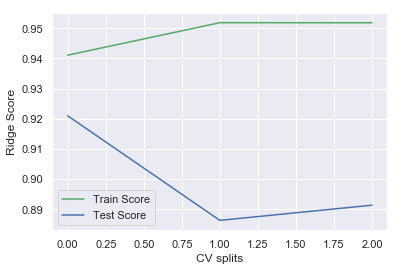

In [82]:
plt.plot(train_score_list, c = 'g', label = 'Train Score')
plt.plot(test_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel('Ridge Score')

Text(0, 0.5, 'Ridge RMSE')

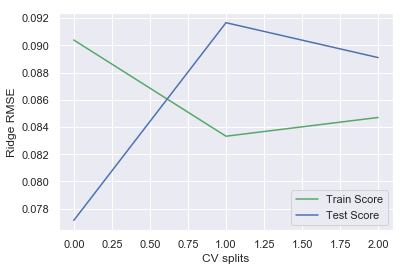

In [83]:
plt.plot(train_rmse_score_list, c = 'g', label = 'Train Score')
plt.plot(test_rmse_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel('Ridge RMSE')

# LinearRegression

For linear regression MinMaxScaling performs really poor on test set and hence will use the hyperparameters given by grid search on unscaled df[features]

In [84]:
parameters = [{'normalize':[True, False], 'fit_intercept':[True, False]}]

grid_search = GridSearchCV(estimator = LinearRegression(), param_grid = parameters, cv=KFold(3, random_state = 0), n_jobs = -1, return_train_score=True)

grid_search = grid_search.fit(df[features],df[target])

print("Grid search best score:", grid_search.best_score_)
print("Grid search best parameters:", grid_search.best_params_)

Grid search best score: 0.8790723712838145
Grid search best parameters: {'fit_intercept': True, 'normalize': False}


In [85]:
regressor_name = "LinearRegression"

train_score_list = []
test_score_list = []
train_rmse_score_list = []
test_rmse_score_list = []

avg_train_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_train_score']
avg_test_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_test_score']

train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_train_score'])

test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_test_score'])

for train, test in grid_search.cv.split(X):
    train_rmse_score_list.append(np.sqrt(mean_squared_error(df[target].iloc[train], grid_search.best_estimator_.predict(df[features].iloc[train]))))
    test_rmse_score_list.append(np.sqrt(mean_squared_error(df[target].iloc[test], grid_search.best_estimator_.predict(df[features].iloc[test]))))

print("3 Fold Train score for",regressor_name,":", train_score_list)
print("3 Fold Test score for",regressor_name,":", test_score_list)
print()
print("Average training score for",regressor_name,"using cross validation:", avg_train_score)
print("Average testing score for",regressor_name,"using cross validation:", avg_test_score)
print()
print("Average training RMSE for",regressor_name,"using cross validation:", sum(train_rmse_score_list) / 3)
print("Average testing RMSE for",regressor_name,"using cross validation:", sum(test_rmse_score_list) / 3)

report_df = report_df.append({"Regressor":regressor_name, "Avg Train Score":avg_train_score, 
                              "Avg Test Score":avg_test_score, "Avg Train RMSE":sum(train_rmse_score_list) / 3,
                              "Avg Test RMSE":sum(test_rmse_score_list) / 3,
                              "Best Hyperparameters" : grid_search.best_params_}, ignore_index=True)

3 Fold Train score for LinearRegression : [0.9463494281231043, 0.9563097817296177, 0.9546776705604075]
3 Fold Test score for LinearRegression : [0.8827988520199587, 0.86216017798104, 0.8922435272850697]

Average training score for LinearRegression using cross validation: 0.9524456268043765
Average testing score for LinearRegression using cross validation: 0.8790723712838145

Average training RMSE for LinearRegression using cross validation: 0.08329667520797479
Average testing RMSE for LinearRegression using cross validation: 0.08317834834622528


# LinearRegression with Pasting

In [86]:
from sklearn.ensemble import BaggingRegressor

param_grid = {"max_samples": [0.5, 1.0],
                          "max_features": [0.5, 1.0],
                          "bootstrap": [False],
                          "bootstrap_features": [True, False]}

grid_search = GridSearchCV(estimator = BaggingRegressor(grid_search.best_estimator_), param_grid = param_grid, cv=KFold(3, random_state = 0), n_jobs = 1, return_train_score=True)

grid_search = grid_search.fit(df[features],df[target])

print("Grid search best Score for",regressor_name,"with pasting:", grid_search.best_score_)
print("Grid search best parameters:", grid_search.best_params_)

Grid search best Score for LinearRegression with pasting: 0.8876930796901874
Grid search best parameters: {'bootstrap': False, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 0.5}


In [87]:
regressor_name = "LinearRegression with Pasting"

train_score_list = []
test_score_list = []
train_rmse_score_list = []
test_rmse_score_list = []

avg_train_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_train_score']
avg_test_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_test_score']

train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_train_score'])

test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_test_score'])

for train, test in grid_search.cv.split(X):
    train_rmse_score_list.append(np.sqrt(mean_squared_error(df[target].iloc[train], grid_search.best_estimator_.predict(df[features].iloc[train]))))
    test_rmse_score_list.append(np.sqrt(mean_squared_error(df[target].iloc[test], grid_search.best_estimator_.predict(df[features].iloc[test]))))

print("3 Fold Train score for",regressor_name,":", train_score_list)
print("3 Fold Test score for",regressor_name,":", test_score_list)
print()
print("Average training score for",regressor_name,"using cross validation:", avg_train_score)
print("Average testing score for",regressor_name,"using cross validation:", avg_test_score)
print()
print("Average training RMSE for",regressor_name,"using cross validation:", sum(train_rmse_score_list) / 3)
print("Average testing RMSE for",regressor_name,"using cross validation:", sum(test_rmse_score_list) / 3)

new_report_df = new_report_df.append({"Regressor":regressor_name, "Avg Train Score":avg_train_score, 
                              "Avg Test Score":avg_test_score, "Avg Train RMSE":sum(train_rmse_score_list) / 3,
                              "Avg Test RMSE":sum(test_rmse_score_list) / 3,
                              "Best Hyperparameters" : grid_search.best_params_}, ignore_index=True)

3 Fold Train score for LinearRegression with Pasting : [0.9344639558673369, 0.951023288303995, 0.9448855581411439]
3 Fold Test score for LinearRegression with Pasting : [0.8997993607459398, 0.8762506724800266, 0.8869819156842219]

Average training score for LinearRegression with Pasting using cross validation: 0.9434576007708252
Average testing score for LinearRegression with Pasting using cross validation: 0.8876930796901874

Average training RMSE for LinearRegression with Pasting using cross validation: 0.08800857651357256
Average testing RMSE for LinearRegression with Pasting using cross validation: 0.08792306313807075


Text(0, 0.5, 'Linear Regression Score')

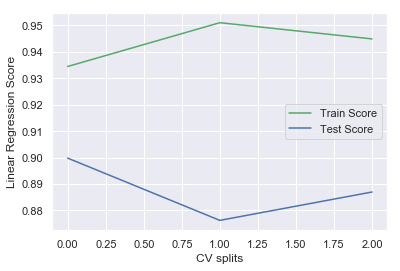

In [88]:
plt.plot(train_score_list, c = 'g', label = 'Train Score')
plt.plot(test_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel('Linear Regression Score')

Text(0, 0.5, 'Linear RMSE')

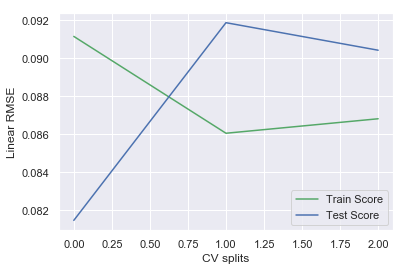

In [89]:
plt.plot(train_rmse_score_list, c = 'g', label = 'Train Score')
plt.plot(test_rmse_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel('Linear RMSE')

# Polynomial Regression

In [92]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

param_grid = {'polynomialfeatures__degree': np.arange(3), 'linearregression__fit_intercept': [True, False], 'linearregression__normalize': [True, False]}

grid_search = GridSearchCV(PolynomialRegression(), param_grid, cv=KFold(3, random_state = 0), n_jobs = -1, return_train_score=True)

grid_search = grid_search.fit(df[features],df[target])

print("Grid search best score:", grid_search.best_score_)
print("Grid search best parameters:", grid_search.best_params_)

Grid search best score: 0.8790723712838225
Grid search best parameters: {'linearregression__fit_intercept': True, 'linearregression__normalize': False, 'polynomialfeatures__degree': 1}


In [93]:
regressor_name = "PolynomialRegression"

train_score_list = []
test_score_list = []
train_rmse_score_list = []
test_rmse_score_list = []

avg_train_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_train_score']
avg_test_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_test_score']

train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_train_score'])

test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_test_score'])    

for train, test in grid_search.cv.split(X):
    train_rmse_score_list.append(np.sqrt(mean_squared_error(df[target].iloc[train], grid_search.best_estimator_.predict(df[features].iloc[train]))))
    test_rmse_score_list.append(np.sqrt(mean_squared_error(df[target].iloc[test], grid_search.best_estimator_.predict(df[features].iloc[test]))))

print("3 Fold Train score for",regressor_name,":", train_score_list)
print("3 Fold Test score for",regressor_name,":", test_score_list)
print()
print("Average training score for",regressor_name,"using cross validation:", avg_train_score)
print("Average testing score for",regressor_name,"using cross validation:", avg_test_score)
print()
print("Average training RMSE for",regressor_name,"using cross validation:", sum(train_rmse_score_list) / 3)
print("Average testing RMSE for",regressor_name,"using cross validation:", sum(test_rmse_score_list) / 3)

report_df = report_df.append({"Regressor":regressor_name, "Avg Train Score":avg_train_score, 
                              "Avg Test Score":avg_test_score, "Avg Train RMSE":sum(train_rmse_score_list) / 3,
                              "Avg Test RMSE":sum(test_rmse_score_list) / 3,
                              "Best Hyperparameters" : grid_search.best_params_}, ignore_index=True)

3 Fold Train score for PolynomialRegression : [0.9463494281231043, 0.9563097817296176, 0.9546776705604078]
3 Fold Test score for PolynomialRegression : [0.8827988520199533, 0.8621601779810291, 0.8922435272851099]

Average training score for PolynomialRegression using cross validation: 0.9524456268043765
Average testing score for PolynomialRegression using cross validation: 0.8790723712838225

Average training RMSE for PolynomialRegression using cross validation: 0.08329667520797479
Average testing RMSE for PolynomialRegression using cross validation: 0.0831783483462253


In [94]:
from sklearn.ensemble import BaggingRegressor

param_grid = {"max_samples": [0.5, 1.0],
                          "max_features": [0.5, 1.0],
                          "bootstrap": [False],
                          "bootstrap_features": [True, False]}

grid_search = GridSearchCV(estimator = BaggingRegressor(grid_search.best_estimator_), param_grid = param_grid, cv=KFold(3, random_state = 0), n_jobs = -1, return_train_score=True)

grid_search = grid_search.fit(df[features],df[target])

print("Grid search best Score for",regressor_name,"with pasting:", grid_search.best_score_)
print("Grid search best parameters:", grid_search.best_params_)

Grid search best Score for PolynomialRegression with pasting: 0.8828530962136861
Grid search best parameters: {'bootstrap': False, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 0.5}


In [95]:
regressor_name = "PolynomialRegression with Pasting"

train_score_list = []
test_score_list = []
train_rmse_score_list = []
test_rmse_score_list = []

avg_train_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_train_score']
avg_test_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_test_score']

train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_train_score'])

test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_test_score'])

for train, test in grid_search.cv.split(X):
    train_rmse_score_list.append(np.sqrt(mean_squared_error(df[target].iloc[train], grid_search.best_estimator_.predict(df[features].iloc[train]))))
    test_rmse_score_list.append(np.sqrt(mean_squared_error(df[target].iloc[test], grid_search.best_estimator_.predict(df[features].iloc[test]))))

print("3 Fold Train score for",regressor_name,":", train_score_list)
print("3 Fold Test score for",regressor_name,":", test_score_list)
print()
print("Average training score for",regressor_name,"using cross validation:", avg_train_score)
print("Average testing score for",regressor_name,"using cross validation:", avg_test_score)
print()
print("Average training RMSE for",regressor_name,"using cross validation:", sum(train_rmse_score_list) / 3)
print("Average testing RMSE for",regressor_name,"using cross validation:", sum(test_rmse_score_list) / 3)

new_report_df = new_report_df.append({"Regressor":regressor_name, "Avg Train Score":avg_train_score, 
                              "Avg Test Score":avg_test_score, "Avg Train RMSE":sum(train_rmse_score_list) / 3,
                              "Avg Test RMSE":sum(test_rmse_score_list) / 3,
                              "Best Hyperparameters" : grid_search.best_params_}, ignore_index=True)

3 Fold Train score for PolynomialRegression with Pasting : [0.9328272052984274, 0.9487649762355571, 0.9436859330310682]
3 Fold Test score for PolynomialRegression with Pasting : [0.8986191171576843, 0.862326617650533, 0.8875519678135285]

Average training score for PolynomialRegression with Pasting using cross validation: 0.9417593715216843
Average testing score for PolynomialRegression with Pasting using cross validation: 0.8828530962136861

Average training RMSE for PolynomialRegression with Pasting using cross validation: 0.08789425861971412
Average testing RMSE for PolynomialRegression with Pasting using cross validation: 0.08774385427485591


Text(0, 0.5, 'Polynomial Regression Score')

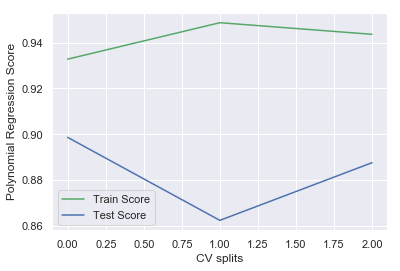

In [96]:
plt.plot(train_score_list, c = 'g', label = 'Train Score')
plt.plot(test_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel('Polynomial Regression Score')

Text(0, 0.5, 'Polynomial RMSE')

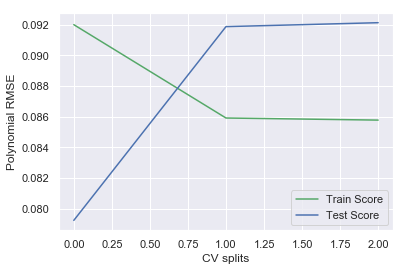

In [97]:
plt.plot(train_rmse_score_list, c = 'g', label = 'Train Score')
plt.plot(test_rmse_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel('Polynomial RMSE')

# KNN Regressor

In [98]:
parameters = [{'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}]

grid_search = GridSearchCV(estimator = KNeighborsRegressor(), param_grid = parameters, cv=KFold(3, random_state = 0), n_jobs = -1, return_train_score=True)

grid_search = grid_search.fit(X,y)

print("Grid search best score:", grid_search.best_score_)
print("Grid search best parameters:", grid_search.best_params_)

Grid search best score: 0.740792796866261
Grid search best parameters: {'n_neighbors': 6}


In [99]:
regressor_name = "kNN Regression"

train_score_list = []
test_score_list = []
train_rmse_score_list = []
test_rmse_score_list = []

avg_train_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_train_score']
avg_test_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_test_score']

train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_train_score'])

test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_test_score'])    

for train, test in grid_search.cv.split(X):
    train_rmse_score_list.append(np.sqrt(mean_squared_error(y.iloc[train], grid_search.best_estimator_.predict(X.iloc[train]))))
    test_rmse_score_list.append(np.sqrt(mean_squared_error(y.iloc[test], grid_search.best_estimator_.predict(X.iloc[test]))))

print("3 Fold Train score for",regressor_name,":", train_score_list)
print("3 Fold Test score for",regressor_name,":", test_score_list)
print()
print("Average training score for",regressor_name,"using cross validation:", avg_train_score)
print("Average testing score for",regressor_name,"using cross validation:", avg_test_score)
print()
print("Average training RMSE for",regressor_name,"using cross validation:", sum(train_rmse_score_list) / 3)
print("Average testing RMSE for",regressor_name,"using cross validation:", sum(test_rmse_score_list) / 3)

report_df = report_df.append({"Regressor":regressor_name, "Avg Train Score":avg_train_score, 
                              "Avg Test Score":avg_test_score, "Avg Train RMSE":sum(train_rmse_score_list) / 3,
                              "Avg Test RMSE":sum(test_rmse_score_list) / 3,
                              "Best Hyperparameters" : grid_search.best_params_}, ignore_index=True)

3 Fold Train score for kNN Regression : [0.81214140041521, 0.8318222523918433, 0.809413854185569]
3 Fold Test score for kNN Regression : [0.7427701757684796, 0.7309783241309644, 0.748622166563002]

Average training score for kNN Regression using cross validation: 0.8177925023308741
Average testing score for kNN Regression using cross validation: 0.740792796866261

Average training RMSE for kNN Regression using cross validation: 0.14697858731183566
Average testing RMSE for kNN Regression using cross validation: 0.14676910842179292


Text(0, 0.5, 'KNN Regression Score')

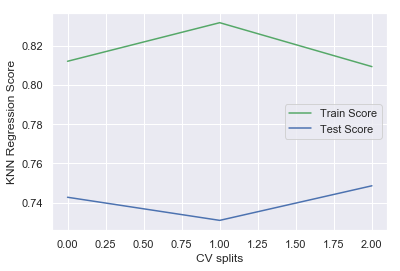

In [100]:
plt.plot(train_score_list, c = 'g', label = 'Train Score')
plt.plot(test_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel('KNN Regression Score')

Text(0, 0.5, 'KNN RMSE')

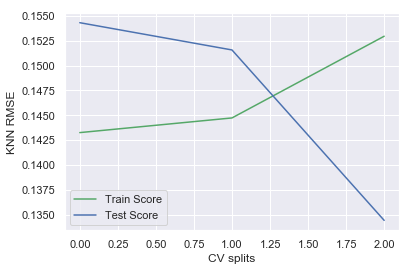

In [101]:
plt.plot(train_rmse_score_list, c = 'g', label = 'Train Score')
plt.plot(test_rmse_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel('KNN RMSE')

# LinearSVR Regression

In [102]:
parameters = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
             'fit_intercept' : [True, False], 'max_iter' : [1000, 2000, 3000, 4000, 5000, 6000],
             'loss' : ['epsilon_insensitive', 'squared_epsilon_insensitive'], "epsilon" : [0, 0.1, 0.5, 0.7, 1, 10]}

grid_search = GridSearchCV(estimator = LinearSVR(), param_grid = parameters, cv=KFold(3, random_state = 0), n_jobs = -1, return_train_score=True)

grid_search = grid_search.fit(df[features],df[target])

print("Grid search best score:", grid_search.best_score_)
print("Grid search best parameters:", grid_search.best_params_)

Grid search best score: 0.8457838486828717
Grid search best parameters: {'C': 10, 'epsilon': 0, 'fit_intercept': True, 'loss': 'epsilon_insensitive', 'max_iter': 6000}


In [103]:
regressor_name = "LinearSVR"

train_score_list = []
test_score_list = []
train_rmse_score_list = []
test_rmse_score_list = []

avg_train_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_train_score']
avg_test_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_test_score']

train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_train_score'])

test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_test_score'])    

for train, test in grid_search.cv.split(X):
    train_rmse_score_list.append(np.sqrt(mean_squared_error(df[target].iloc[train], grid_search.best_estimator_.predict(df[features].iloc[train]))))
    test_rmse_score_list.append(np.sqrt(mean_squared_error(df[target].iloc[test], grid_search.best_estimator_.predict(df[features].iloc[test]))))

print("3 Fold Train score for",regressor_name,":", train_score_list)
print("3 Fold Test score for",regressor_name,":", test_score_list)
print()
print("Average training score for",regressor_name,"using cross validation:", avg_train_score)
print("Average testing score for",regressor_name,"using cross validation:", avg_test_score)
print()
print("Average training RMSE for",regressor_name,"using cross validation:", sum(train_rmse_score_list) / 3)
print("Average testing RMSE for",regressor_name,"using cross validation:", sum(test_rmse_score_list) / 3)

report_df = report_df.append({"Regressor":regressor_name, "Avg Train Score":avg_train_score, 
                              "Avg Test Score":avg_test_score, "Avg Train RMSE":sum(train_rmse_score_list) / 3,
                              "Avg Test RMSE":sum(test_rmse_score_list) / 3,
                              "Best Hyperparameters" : grid_search.best_params_}, ignore_index=True)

3 Fold Train score for LinearSVR : [0.8801480833188217, 0.8727829780844576, 0.8920362593630132]
3 Fold Test score for LinearSVR : [0.8654127295039632, 0.8178236314843343, 0.8540385097446102]

Average training score for LinearSVR using cross validation: 0.8816557735887641
Average testing score for LinearSVR using cross validation: 0.8457838486828717

Average training RMSE for LinearSVR using cross validation: 0.133505570097773
Average testing RMSE for LinearSVR using cross validation: 0.13339103668113916


Text(0, 0.5, 'LinearSVR Score')

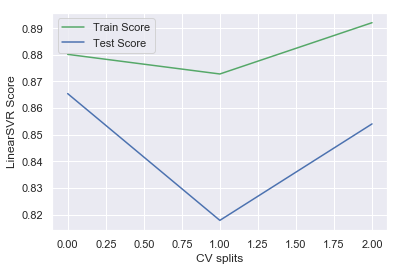

In [104]:
plt.plot(train_score_list, c = 'g', label = 'Train Score')
plt.plot(test_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel('LinearSVR Score')

Text(0, 0.5, 'LinearSVR RMSE')

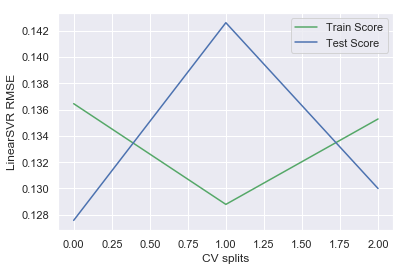

In [105]:
plt.plot(train_rmse_score_list, c = 'g', label = 'Train Score')
plt.plot(test_rmse_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel('LinearSVR RMSE')

# GredientBoosting Regression

In [107]:
param_grid = {"learning_rate": [0.01, 0.1, 0.5, 1],
              "max_depth": [5, 10, 25, 50],
             "max_leaf_nodes" : [None, 10, 20, 50, 70, 100]}

grid_search = GridSearchCV(estimator = GradientBoostingRegressor(), param_grid = param_grid, cv=KFold(3, random_state = 0), n_jobs = -1, return_train_score=True)

grid_search = grid_search.fit(X,y)

print("Grid search best Score for",regressor_name,":", grid_search.best_score_)
print("Grid search best parameters:", grid_search.best_params_)

Grid search best Score for LinearSVR : 0.8887952991522801
Grid search best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'max_leaf_nodes': 10}


In [108]:
regressor_name = "GredientBoosting Regression"

train_score_list = []
test_score_list = []
train_rmse_score_list = []
test_rmse_score_list = []

avg_train_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_train_score']
avg_test_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_test_score']

train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_train_score'])

test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_test_score'])

for train, test in grid_search.cv.split(X):
    train_rmse_score_list.append(np.sqrt(mean_squared_error(y.iloc[train], grid_search.best_estimator_.predict(X.iloc[train]))))
    test_rmse_score_list.append(np.sqrt(mean_squared_error(y.iloc[test], grid_search.best_estimator_.predict(X.iloc[test]))))

print("3 Fold Train score for",regressor_name,":", train_score_list)
print("3 Fold Test score for",regressor_name,":", test_score_list)
print()
print("Average training score for",regressor_name,"using cross validation:", avg_train_score)
print("Average testing score for",regressor_name,"using cross validation:", avg_test_score)
print()
print("Average training RMSE for",regressor_name,"using cross validation:", sum(train_rmse_score_list) / 3)
print("Average testing RMSE for",regressor_name,"using cross validation:", sum(test_rmse_score_list) / 3)

new_report_df = new_report_df.append({"Regressor":regressor_name, "Avg Train Score":avg_train_score, 
                              "Avg Test Score":avg_test_score, "Avg Train RMSE":sum(train_rmse_score_list) / 3,
                              "Avg Test RMSE":sum(test_rmse_score_list) / 3,
                              "Best Hyperparameters" : grid_search.best_params_}, ignore_index=True)

3 Fold Train score for GredientBoosting Regression : [0.9881154113173808, 0.9872954790341081, 0.9891037050508553]
3 Fold Test score for GredientBoosting Regression : [0.9091643775477857, 0.8786324037216727, 0.8785095494748989]

Average training score for GredientBoosting Regression using cross validation: 0.9881715318007814
Average testing score for GredientBoosting Regression using cross validation: 0.8887952991522801

Average training RMSE for GredientBoosting Regression using cross validation: 0.050802847779034536
Average testing RMSE for GredientBoosting Regression using cross validation: 0.050798247663052847


Text(0, 0.5, 'Gradient boosting Score')

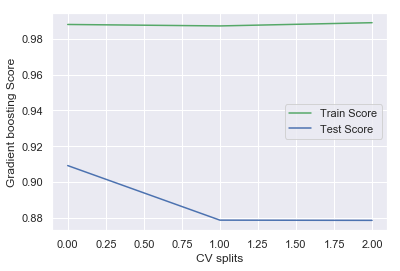

In [109]:
plt.plot(train_score_list, c = 'g', label = 'Train Score')
plt.plot(test_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel('Gradient boosting Score')

Text(0, 0.5, 'Gradient boosting RMSE')

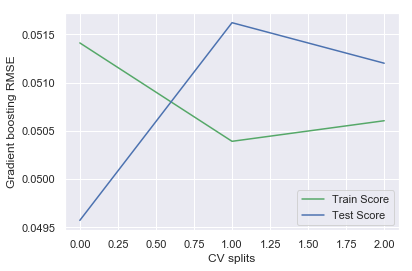

In [110]:
plt.plot(train_rmse_score_list, c = 'g', label = 'Train Score')
plt.plot(test_rmse_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel('Gradient boosting RMSE')

# Kernalized SVR Regression

In [111]:
parameters = [{'C':[0.001, 0.01, 0.1, 1, 10, 100], 'kernel':['rbf','linear','poly'], 'gamma':[0.001, 0.01, 0.1, 1, 10, 100]}]

grid_search = GridSearchCV(estimator = SVR(), param_grid = parameters, cv=KFold(3, random_state = 0), n_jobs = -1, return_train_score=True)

grid_search = grid_search.fit(X,y)

print("Grid search best score:", grid_search.best_score_)
print("Grid search best parameters:", grid_search.best_params_)

Grid search best score: 0.8921621913769473
Grid search best parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


In [112]:
regressor_name = "KernalizedSVR Regression"

train_score_list = []
test_score_list = []
train_rmse_score_list = []
test_rmse_score_list = []

avg_train_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_train_score']
avg_test_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_test_score']

train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_train_score'])

test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_test_score'])    

for train, test in grid_search.cv.split(X):
    train_rmse_score_list.append(np.sqrt(mean_squared_error(y.iloc[train], grid_search.best_estimator_.predict(X.iloc[train]))))
    test_rmse_score_list.append(np.sqrt(mean_squared_error(y.iloc[test], grid_search.best_estimator_.predict(X.iloc[test]))))

print("3 Fold Train score for",regressor_name,":", train_score_list)
print("3 Fold Test score for",regressor_name,":", test_score_list)
print()
print("Average training score for",regressor_name,"using cross validation:", avg_train_score)
print("Average testing score for",regressor_name,"using cross validation:", avg_test_score)
print()
print("Average training RMSE for",regressor_name,"using cross validation:", sum(train_rmse_score_list) / 3)
print("Average testing RMSE for",regressor_name,"using cross validation:", sum(test_rmse_score_list) / 3)

report_df = report_df.append({"Regressor":regressor_name, "Avg Train Score":avg_train_score, 
                              "Avg Test Score":avg_test_score, "Avg Train RMSE":sum(train_rmse_score_list) / 3,
                              "Avg Test RMSE":sum(test_rmse_score_list) / 3,
                              "Best Hyperparameters" : grid_search.best_params_}, ignore_index=True)

3 Fold Train score for KernalizedSVR Regression : [0.9465267279061154, 0.9538229471274837, 0.9572941325281688]
3 Fold Test score for KernalizedSVR Regression : [0.9160182517759312, 0.8856809355639369, 0.8746941990550403]

Average training score for KernalizedSVR Regression using cross validation: 0.9525479358539227
Average testing score for KernalizedSVR Regression using cross validation: 0.8921621913769473

Average training RMSE for KernalizedSVR Regression using cross validation: 0.07757772203725029
Average testing RMSE for KernalizedSVR Regression using cross validation: 0.07747359041648282


Text(0, 0.5, 'Kernalized SVR Score')

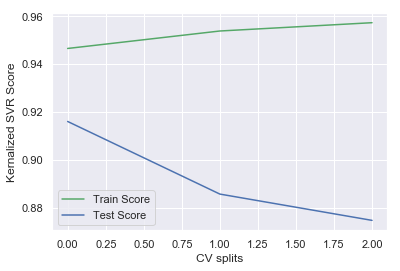

In [113]:
plt.plot(train_score_list, c = 'g', label = 'Train Score')
plt.plot(test_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel('Kernalized SVR Score')

Text(0, 0.5, 'KernelizedSVR RMSE')

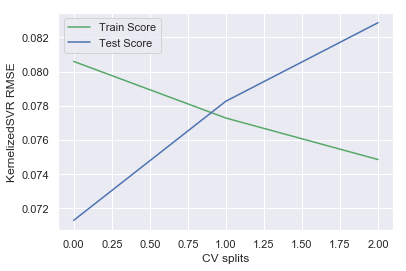

In [114]:
plt.plot(train_rmse_score_list, c = 'g', label = 'Train Score')
plt.plot(test_rmse_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel('KernelizedSVR RMSE')

# DecisionTree Regression

In [120]:
parameters = [{'max_depth':np.arange(1, 21), 'min_samples_leaf':[1, 5, 10, 15, 20, 25, 50, 100],
              'min_samples_split':[10, 20, 30, 50, 70, 100], 'max_features' : [None, 10, 30, 50, 70, 100, 120, 142]}]

grid_search = GridSearchCV(estimator = DecisionTreeRegressor(), param_grid = parameters, cv=KFold(3, random_state = 0), n_jobs = -1, return_train_score=True)

grid_search = grid_search.fit(df[features],df[target])

print("Grid search best score:", grid_search.best_score_)
print("Grid search best parameters:", grid_search.best_params_)

Grid search best score: 0.8067002609522362
Grid search best parameters: {'max_depth': 16, 'max_features': 120, 'min_samples_leaf': 5, 'min_samples_split': 20}


In [116]:
regressor_name = "DecisionTree Regression"

train_score_list = []
test_score_list = []
train_rmse_score_list = []
test_rmse_score_list = []

avg_train_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_train_score']
avg_test_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_test_score']

train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_train_score'])

test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_test_score'])    

for train, test in grid_search.cv.split(X):
    train_rmse_score_list.append(np.sqrt(mean_squared_error(df[target].iloc[train], grid_search.best_estimator_.predict(df[features].iloc[train]))))
    test_rmse_score_list.append(np.sqrt(mean_squared_error(df[target].iloc[test], grid_search.best_estimator_.predict(df[features].iloc[test]))))

print("3 Fold Train score for",regressor_name,":", train_score_list)
print("3 Fold Test score for",regressor_name,":", test_score_list)
print()
print("Average training score for",regressor_name,"using cross validation:", avg_train_score)
print("Average testing score for",regressor_name,"using cross validation:", avg_test_score)
print()
print("Average training RMSE for",regressor_name,"using cross validation:", sum(train_rmse_score_list) / 3)
print("Average testing RMSE for",regressor_name,"using cross validation:", sum(test_rmse_score_list) / 3)

report_df = report_df.append({"Regressor":regressor_name, "Avg Train Score":avg_train_score, 
                              "Avg Test Score":avg_test_score, "Avg Train RMSE":sum(train_rmse_score_list) / 3,
                              "Avg Test RMSE":sum(test_rmse_score_list) / 3,
                              "Best Hyperparameters" : grid_search.best_params_}, ignore_index=True)

3 Fold Train score for DecisionTree Regression : [0.8889912924199626, 0.8981785741551668, 0.8968378379013148]
3 Fold Test score for DecisionTree Regression : [0.8080228636750731, 0.8465058159594041, 0.7719940641178134]

Average training score for DecisionTree Regression using cross validation: 0.8946692348254813
Average testing score for DecisionTree Regression using cross validation: 0.8088398507987796

Average training RMSE for DecisionTree Regression using cross validation: 0.1097474544955036
Average testing RMSE for DecisionTree Regression using cross validation: 0.10973819542663611


In [121]:
from sklearn.ensemble import BaggingRegressor

param_grid = {"max_samples": [0.5, 1.0],
                          "bootstrap": [True],
                          "bootstrap_features": [True, False], "oob_score" : [True, False]}

grid_search = GridSearchCV(estimator = BaggingRegressor(grid_search.best_estimator_), param_grid = param_grid, cv=KFold(3, random_state = 0), n_jobs = -1, return_train_score=True)

grid_search = grid_search.fit(df[features],df[target])

print("Grid search best Score for",regressor_name,"with Bagging:", grid_search.best_score_)
print("Grid search best parameters:", grid_search.best_params_)

Grid search best Score for DecisionTree Regression with Bagging: 0.8556966003057997
Grid search best parameters: {'bootstrap': True, 'bootstrap_features': True, 'max_samples': 1.0, 'oob_score': False}


# DecisionTree Regression with Bagging

In [122]:
regressor_name = "DecisionTree with Bagging"

train_score_list = []
test_score_list = []
train_rmse_score_list = []
test_rmse_score_list = []

avg_train_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_train_score']
avg_test_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_test_score']

train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_train_score'])

test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_test_score'])

for train, test in grid_search.cv.split(X):
    train_rmse_score_list.append(np.sqrt(mean_squared_error(df[target].iloc[train], grid_search.best_estimator_.predict(df[features].iloc[train]))))
    test_rmse_score_list.append(np.sqrt(mean_squared_error(df[target].iloc[test], grid_search.best_estimator_.predict(df[features].iloc[test]))))

print("3 Fold Train score for",regressor_name,":", train_score_list)
print("3 Fold Test score for",regressor_name,":", test_score_list)
print()
print("Average training score for",regressor_name,"using cross validation:", avg_train_score)
print("Average testing score for",regressor_name,"using cross validation:", avg_test_score)
print()
print("Average training RMSE for",regressor_name,"using cross validation:", sum(train_rmse_score_list) / 3)
print("Average testing RMSE for",regressor_name,"using cross validation:", sum(test_rmse_score_list) / 3)

new_report_df = new_report_df.append({"Regressor":regressor_name, "Avg Train Score":avg_train_score, 
                              "Avg Test Score":avg_test_score, "Avg Train RMSE":sum(train_rmse_score_list) / 3,
                              "Avg Test RMSE":sum(test_rmse_score_list) / 3,
                              "Best Hyperparameters" : grid_search.best_params_}, ignore_index=True)

3 Fold Train score for DecisionTree with Bagging : [0.9131669713435923, 0.916104481451703, 0.9174645133558176]
3 Fold Test score for DecisionTree with Bagging : [0.8656125472801931, 0.8614733659427609, 0.8399651535265766]

Average training score for DecisionTree with Bagging using cross validation: 0.9155786553837043
Average testing score for DecisionTree with Bagging using cross validation: 0.8556966003057997

Average training RMSE for DecisionTree with Bagging using cross validation: 0.10226358692662774
Average testing RMSE for DecisionTree with Bagging using cross validation: 0.1022623342789931


Text(0, 0.5, 'DecisionTree with Bagging Score')

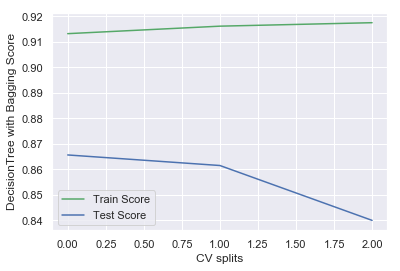

In [123]:
plt.plot(train_score_list, c = 'g', label = 'Train Score')
plt.plot(test_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel(regressor_name+' Score')

Text(0, 0.5, 'DecisionTree with Bagging RMSE')

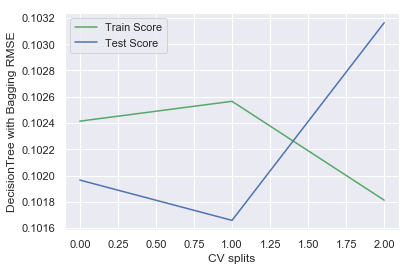

In [124]:
plt.plot(train_rmse_score_list, c = 'g', label = 'Train Score')
plt.plot(test_rmse_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel(regressor_name+' RMSE')

# SGD Regression

In [129]:
parameters = [{'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                'penalty': ['l2', 'l1', 'elasticnet'],
                'learning_rate': ['constant', 'optimal', 'invscaling']}]

grid_search = GridSearchCV(estimator = SGDRegressor(), param_grid = parameters, cv=KFold(3, random_state = 0), n_jobs = -1, return_train_score=True)

grid_search = grid_search.fit(X,y)

print("Grid search best score:", grid_search.best_score_)
print("Grid search best parameters:", grid_search.best_params_)

Grid search best score: 0.8053013314727611
Grid search best parameters: {'alpha': 0.1, 'learning_rate': 'constant', 'penalty': 'l2'}


In [126]:
regressor_name = "StochasticGradientDecent Regression"

train_score_list = []
test_score_list = []
train_rmse_score_list = []
test_rmse_score_list = []

avg_train_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_train_score']
avg_test_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_test_score']

train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_train_score'])

test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_test_score'])    

for train, test in grid_search.cv.split(X):
    train_rmse_score_list.append(np.sqrt(mean_squared_error(y.iloc[train], grid_search.best_estimator_.predict(X.iloc[train]))))
    test_rmse_score_list.append(np.sqrt(mean_squared_error(y.iloc[test], grid_search.best_estimator_.predict(X.iloc[test]))))

print("3 Fold Train score for",regressor_name,":", train_score_list)
print("3 Fold Test score for",regressor_name,":", test_score_list)
print()
print("Average training score for",regressor_name,"using cross validation:", avg_train_score)
print("Average testing score for",regressor_name,"using cross validation:", avg_test_score)
print()
print("Average training RMSE for",regressor_name,"using cross validation:", sum(train_rmse_score_list) / 3)
print("Average testing RMSE for",regressor_name,"using cross validation:", sum(test_rmse_score_list) / 3)

report_df = report_df.append({"Regressor":regressor_name, "Avg Train Score":avg_train_score, 
                              "Avg Test Score":avg_test_score, "Avg Train RMSE":sum(train_rmse_score_list) / 3,
                              "Avg Test RMSE":sum(test_rmse_score_list) / 3,
                              "Best Hyperparameters" : grid_search.best_params_}, ignore_index=True)

3 Fold Train score for StochasticGradientDecent Regression : [0.8185490695261509, 0.8557471846955613, 0.8595409851616543]
3 Fold Test score for StochasticGradientDecent Regression : [0.83443005917822, 0.8028428966235657, 0.841191668403721]

Average training score for StochasticGradientDecent Regression using cross validation: 0.8446124131277889
Average testing score for StochasticGradientDecent Regression using cross validation: 0.8261656357032352

Average training RMSE for StochasticGradientDecent Regression using cross validation: 0.13218702089972745
Average testing RMSE for StochasticGradientDecent Regression using cross validation: 0.13208438198971492


# StochasticGradientDecent Regression with Bagging

In [130]:
from sklearn.ensemble import BaggingRegressor

param_grid = {"max_samples": [0.5, 1.0],
                          "max_features": [0.5, 1.0],
                          "bootstrap": [True],
                          "bootstrap_features": [True, False],
                             "oob_score" : [True, False]}

grid_search = GridSearchCV(estimator = BaggingRegressor(grid_search.best_estimator_), param_grid = param_grid, cv=KFold(3, random_state = 0), n_jobs = -1, return_train_score=True)

grid_search = grid_search.fit(X,y)

print("Grid search best Score for",regressor_name,"with bagging:", grid_search.best_score_)
print("Grid search best parameters:", grid_search.best_params_)

Grid search best Score for StochasticGradientDecent Regression with bagging: 0.8461058950479321
Grid search best parameters: {'bootstrap': True, 'bootstrap_features': True, 'max_features': 1.0, 'max_samples': 1.0, 'oob_score': True}


In [131]:
regressor_name = "StochasticGradientDecent with Bagging"

train_score_list = []
test_score_list = []
train_rmse_score_list = []
test_rmse_score_list = []

avg_train_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_train_score']
avg_test_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_test_score']

train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_train_score'])

test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_test_score'])

for train, test in grid_search.cv.split(X):
    train_rmse_score_list.append(np.sqrt(mean_squared_error(y.iloc[train], grid_search.best_estimator_.predict(X.iloc[train]))))
    test_rmse_score_list.append(np.sqrt(mean_squared_error(y.iloc[test], grid_search.best_estimator_.predict(X.iloc[test]))))

print("3 Fold Train score for",regressor_name,":", train_score_list)
print("3 Fold Test score for",regressor_name,":", test_score_list)
print()
print("Average training score for",regressor_name,"using cross validation:", avg_train_score)
print("Average testing score for",regressor_name,"using cross validation:", avg_test_score)
print()
print("Average training RMSE for",regressor_name,"using cross validation:", sum(train_rmse_score_list) / 3)
print("Average testing RMSE for",regressor_name,"using cross validation:", sum(test_rmse_score_list) / 3)

new_report_df = new_report_df.append({"Regressor":regressor_name, "Avg Train Score":avg_train_score, 
                              "Avg Test Score":avg_test_score, "Avg Train RMSE":sum(train_rmse_score_list) / 3,
                              "Avg Test RMSE":sum(test_rmse_score_list) / 3,
                              "Best Hyperparameters" : grid_search.best_params_}, ignore_index=True)

3 Fold Train score for StochasticGradientDecent with Bagging : [0.8580439862060909, 0.8647223960133754, 0.8708736457638879]
3 Fold Test score for StochasticGradientDecent with Bagging : [0.8594489873457042, 0.8327708474124718, 0.8460457289313325]

Average training score for StochasticGradientDecent with Bagging using cross validation: 0.8645466759944513
Average testing score for StochasticGradientDecent with Bagging using cross validation: 0.8461058950479321

Average training RMSE for StochasticGradientDecent with Bagging using cross validation: 0.13677960818129822
Average testing RMSE for StochasticGradientDecent with Bagging using cross validation: 0.1366552011778584


Text(0, 0.5, 'StochasticGradientDecent with Bagging Score')

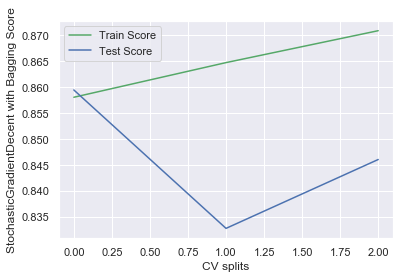

In [132]:
plt.plot(train_score_list, c = 'g', label = 'Train Score')
plt.plot(test_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel(regressor_name+' Score')

Text(0, 0.5, 'StochasticGradientDecent with Bagging RMSE')

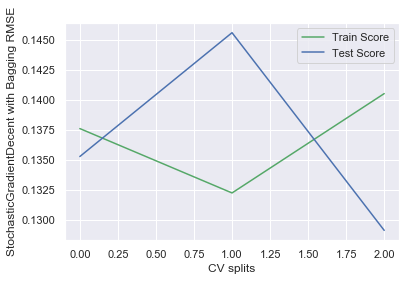

In [133]:
plt.plot(train_rmse_score_list, c = 'g', label = 'Train Score')
plt.plot(test_rmse_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel(regressor_name+' RMSE')

Lets save the report of model results without PCA for evaluation later.

In [134]:
old_models_results = report_df.copy()
old_models_with_ensemble_results = new_report_df.copy()

Lets create a new dataframe for storing results of models after applying PCA

In [135]:
pca_report_df = pd.DataFrame(columns=["Regressor", "Avg Train Score", "Avg Test Score", "Avg Train RMSE", "Avg Test RMSE", "Best Hyperparameters"])

# PCA

<div class="post-text" itemprop="text">
<p>Data on which the PCA-transformation is calculated should be normalized, meaning in this case:</p>

<ul>
<li>zero mean</li>
<li>unit variance</li>
</ul>

<p>This basically is sklearns <code>StandardScaler</code>, which i would prefer of your candidates. The reasons are explained on <a href="https://en.wikipedia.org/wiki/Principal_component_analysis" rel="nofollow">Wiki</a> and also <a href="https://www.researchgate.net/post/Is_it_necessary_to_normalize_data_before_performing_principle_component_analysis" rel="nofollow">here</a>.</p>

<ul>
<li>sklearns Normalizer is missing zero-mean</li>
<li>Both Min-Max scalers are missing unit-variance</li>
<li>Robust scaler could work on some data (outliers!), but i would prefer StandardScaler.</li>
</ul>
    </div>

In [136]:
pca1 = PCA(n_components = 0.95)
pca2 = PCA(n_components = 0.9999)
X = pca1.fit_transform(StandardScaler().fit_transform(df[features]))
y = df[target]
# For the models which require scaling
#X = pca1.fit_transform(MinMaxScaler().fit_transform(df[features]))

# For the models which do not require scaling
X_org = pca2.fit_transform(df[features])

In [137]:
pca1.n_components_

91

In [138]:
pca2.n_components_

18

In [139]:
np.sum(pca1.explained_variance_ratio_)

0.9508791652892298

In [140]:
np.sum(pca2.explained_variance_ratio_)

0.9999038594676702

# Lasso

In [141]:
parameters = [{'alpha':[0.001,0.01,0.1,1,10,100]}]

grid_search = GridSearchCV(estimator = Lasso(), param_grid = parameters, cv=KFold(3, random_state = 0), n_jobs = -1, return_train_score=True)

grid_search = grid_search.fit(X,y)

print("Grid search best Score:", grid_search.best_score_)
print("Grid search best parameters:", grid_search.best_params_)

Grid search best Score: 0.8717611543262455
Grid search best parameters: {'alpha': 0.01}


In [142]:
regressor_name = "Lasso with PCA"

train_score_list = []
test_score_list = []
train_rmse_score_list = []
test_rmse_score_list = []

avg_train_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_train_score']
avg_test_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_test_score']

train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_train_score'])

test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_test_score'])

for train, test in grid_search.cv.split(X):
    train_rmse_score_list.append(np.sqrt(mean_squared_error(y.iloc[train], grid_search.best_estimator_.predict(X[train]))))
    test_rmse_score_list.append(np.sqrt(mean_squared_error(y.iloc[test], grid_search.best_estimator_.predict(X[test]))))

print("3 Fold Train score for",regressor_name,":", train_score_list)
print("3 Fold Test score for",regressor_name,":", test_score_list)
print()
print("Average training score for",regressor_name,"using cross validation:", avg_train_score)
print("Average testing score for",regressor_name,"using cross validation:", avg_test_score)
print()
print("Average training RMSE for",regressor_name,"using cross validation:", sum(train_rmse_score_list) / 3)
print("Average testing RMSE for",regressor_name,"using cross validation:", sum(test_rmse_score_list) / 3)

pca_report_df = pca_report_df.append({"Regressor":regressor_name, "Avg Train Score":avg_train_score, 
                              "Avg Test Score":avg_test_score, "Avg Train RMSE":sum(train_rmse_score_list) / 3,
                              "Avg Test RMSE":sum(test_rmse_score_list) / 3,
                              "Best Hyperparameters" : grid_search.best_params_}, ignore_index=True)

3 Fold Train score for Lasso with PCA : [0.8826460222162589, 0.8965309664900281, 0.8955245704137715]
3 Fold Test score for Lasso with PCA : [0.8812847048484429, 0.8666715460487501, 0.8672900107123162]

Average training score for Lasso with PCA using cross validation: 0.8915671863733529
Average testing score for Lasso with PCA using cross validation: 0.8717611543262455

Average training RMSE for Lasso with PCA using cross validation: 0.12095778204801678
Average testing RMSE for Lasso with PCA using cross validation: 0.12086608214019283


Text(0, 0.5, 'Lasso with PCA Score')

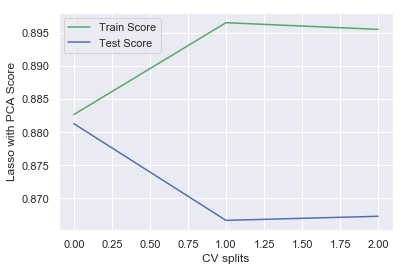

In [143]:
plt.plot(train_score_list, c = 'g', label = 'Train Score')
plt.plot(test_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel(regressor_name+' Score')

Text(0, 0.5, 'Lasso with PCA RMSE')

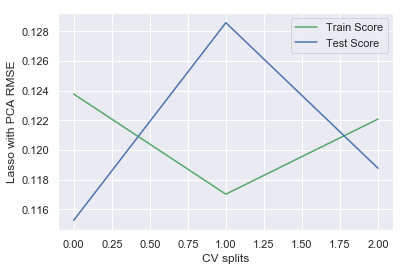

In [144]:
plt.plot(train_rmse_score_list, c = 'g', label = 'Train Score')
plt.plot(test_rmse_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel(regressor_name+' RMSE')

# Ridge

In [146]:
parameters = [{'alpha':[0.001,0.01,0.1,1,10,100,1000]}]

grid_search = GridSearchCV(estimator = Ridge(), param_grid = parameters, cv=KFold(3, random_state = 0), n_jobs = -1, return_train_score=True)

grid_search = grid_search.fit(X,y)

print("Grid search best score:", grid_search.best_score_)
print("Grid search best parameters:", grid_search.best_params_)

Grid search best score: 0.8867266390936841
Grid search best parameters: {'alpha': 100}


In [147]:
regressor_name = "Ridge with PCA"

train_score_list = []
test_score_list = []
train_rmse_score_list = []
test_rmse_score_list = []

avg_train_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_train_score']
avg_test_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_test_score']

train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_train_score'])

test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_test_score'])

for train, test in grid_search.cv.split(X):
    train_rmse_score_list.append(np.sqrt(mean_squared_error(y.iloc[train], grid_search.best_estimator_.predict(X[train]))))
    test_rmse_score_list.append(np.sqrt(mean_squared_error(y.iloc[test], grid_search.best_estimator_.predict(X[test]))))

print("3 Fold Train score for",regressor_name,":", train_score_list)
print("3 Fold Test score for",regressor_name,":", test_score_list)
print()
print("Average training score for",regressor_name,"using cross validation:", avg_train_score)
print("Average testing score for",regressor_name,"using cross validation:", avg_test_score)
print()
print("Average training RMSE for",regressor_name,"using cross validation:", sum(train_rmse_score_list) / 3)
print("Average testing RMSE for",regressor_name,"using cross validation:", sum(test_rmse_score_list) / 3)

pca_report_df = pca_report_df.append({"Regressor":regressor_name, "Avg Train Score":avg_train_score, 
                              "Avg Test Score":avg_test_score, "Avg Train RMSE":sum(train_rmse_score_list) / 3,
                              "Avg Test RMSE":sum(test_rmse_score_list) / 3,
                              "Best Hyperparameters" : grid_search.best_params_}, ignore_index=True)

3 Fold Train score for Ridge with PCA : [0.914820172442063, 0.9234101255260514, 0.9287801660779467]
3 Fold Test score for Ridge with PCA : [0.9004669379525541, 0.8834474256233643, 0.8762118806627166]

Average training score for Ridge with PCA using cross validation: 0.922336821348687
Average testing score for Ridge with PCA using cross validation: 0.8867266390936841

Average training RMSE for Ridge with PCA using cross validation: 0.10256387891461129
Average testing RMSE for Ridge with PCA using cross validation: 0.10248178083135621


Text(0, 0.5, 'Ridge with PCA Score')

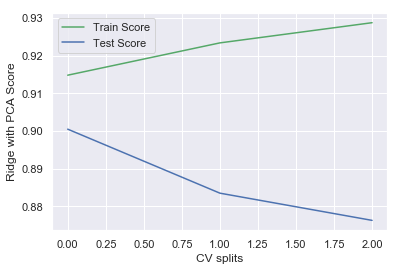

In [148]:
plt.plot(train_score_list, c = 'g', label = 'Train Score')
plt.plot(test_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel(regressor_name+' Score')

Text(0, 0.5, 'Ridge with PCA RMSE')

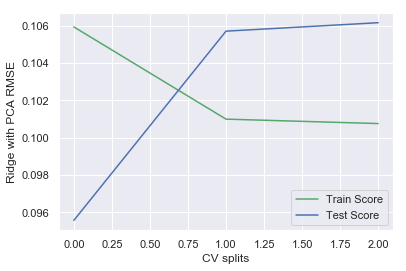

In [149]:
plt.plot(train_rmse_score_list, c = 'g', label = 'Train Score')
plt.plot(test_rmse_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel(regressor_name+' RMSE')

# LinearRegression

For linear regression MinMaxScaling performs really poor on test set and hence will use the hyperparameters given by grid search on unscaled X_train = train_df[features]

In [150]:
parameters = [{'normalize':[True, False], 'fit_intercept':[True, False]}]

grid_search = GridSearchCV(estimator = LinearRegression(), param_grid = parameters, cv=KFold(3, random_state = 0), n_jobs = -1, return_train_score=True)

grid_search = grid_search.fit(X_org, y)

print("Grid search best score:", grid_search.best_score_)
print("Grid search best parameters:", grid_search.best_params_)

Grid search best score: 0.8449807413224677
Grid search best parameters: {'fit_intercept': True, 'normalize': True}


In [151]:
regressor_name = "LinearRegression with PCA"

train_score_list = []
test_score_list = []
train_rmse_score_list = []
test_rmse_score_list = []

avg_train_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_train_score']
avg_test_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_test_score']

train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_train_score'])

test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_test_score'])

for train, test in grid_search.cv.split(X_org):
    train_rmse_score_list.append(np.sqrt(mean_squared_error(df[target].iloc[train], grid_search.best_estimator_.predict(X_org[train]))))
    test_rmse_score_list.append(np.sqrt(mean_squared_error(df[target].iloc[test], grid_search.best_estimator_.predict(X_org[test]))))

print("3 Fold Train score for",regressor_name,":", train_score_list)
print("3 Fold Test score for",regressor_name,":", test_score_list)
print()
print("Average training score for",regressor_name,"using cross validation:", avg_train_score)
print("Average testing score for",regressor_name,"using cross validation:", avg_test_score)
print()
print("Average training RMSE for",regressor_name,"using cross validation:", sum(train_rmse_score_list) / 3)
print("Average testing RMSE for",regressor_name,"using cross validation:", sum(test_rmse_score_list) / 3)

pca_report_df = pca_report_df.append({"Regressor":regressor_name, "Avg Train Score":avg_train_score, 
                              "Avg Test Score":avg_test_score, "Avg Train RMSE":sum(train_rmse_score_list) / 3,
                              "Avg Test RMSE":sum(test_rmse_score_list) / 3,
                              "Best Hyperparameters" : grid_search.best_params_}, ignore_index=True)

3 Fold Train score for LinearRegression with PCA : [0.8499944028504168, 0.8583456237352737, 0.8579913951872248]
3 Fold Test score for LinearRegression with PCA : [0.8554461922013926, 0.8414813593722096, 0.8379737917263049]

Average training score for LinearRegression with PCA using cross validation: 0.8554438072576384
Average testing score for LinearRegression with PCA using cross validation: 0.8449807413224677

Average training RMSE for LinearRegression with PCA using cross validation: 0.13704726061790304
Average testing RMSE for LinearRegression with PCA using cross validation: 0.1370163336342112


Text(0, 0.5, 'LinearRegression with PCA Score')

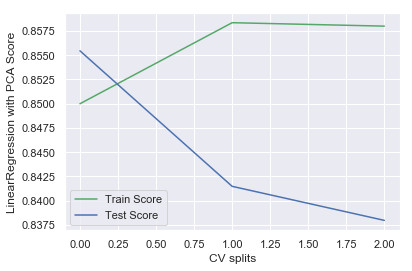

In [152]:
plt.plot(train_score_list, c = 'g', label = 'Train Score')
plt.plot(test_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel(regressor_name+' Score')

Text(0, 0.5, 'LinearRegression with PCA RMSE')

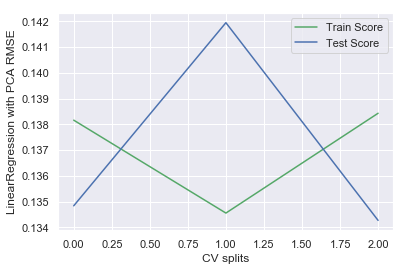

In [153]:
plt.plot(train_rmse_score_list, c = 'g', label = 'Train Score')
plt.plot(test_rmse_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel(regressor_name+' RMSE')

# Polynomial Regression

In [154]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

param_grid = {'polynomialfeatures__degree': np.arange(3), 'linearregression__fit_intercept': [True, False], 'linearregression__normalize': [True, False]}

grid_search = GridSearchCV(PolynomialRegression(), param_grid, cv=KFold(3, random_state = 0), n_jobs = -1, return_train_score=True)

grid_search = grid_search.fit(X_org,y)

print("Grid search best score:", grid_search.best_score_)
print("Grid search best parameters:", grid_search.best_params_)

Grid search best score: 0.8449807413224677
Grid search best parameters: {'linearregression__fit_intercept': True, 'linearregression__normalize': True, 'polynomialfeatures__degree': 1}


In [155]:
regressor_name = "PolynomialRegression with PCA"

train_score_list = []
test_score_list = []
train_rmse_score_list = []
test_rmse_score_list = []

avg_train_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_train_score']
avg_test_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_test_score']

train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_train_score'])

test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_test_score'])    

for train, test in grid_search.cv.split(X_org):
    train_rmse_score_list.append(np.sqrt(mean_squared_error(df[target].iloc[train], grid_search.best_estimator_.predict(X_org[train]))))
    test_rmse_score_list.append(np.sqrt(mean_squared_error(df[target].iloc[test], grid_search.best_estimator_.predict(X_org[test]))))

print("3 Fold Train score for",regressor_name,":", train_score_list)
print("3 Fold Test score for",regressor_name,":", test_score_list)
print()
print("Average training score for",regressor_name,"using cross validation:", avg_train_score)
print("Average testing score for",regressor_name,"using cross validation:", avg_test_score)
print()
print("Average training RMSE for",regressor_name,"using cross validation:", sum(train_rmse_score_list) / 3)
print("Average testing RMSE for",regressor_name,"using cross validation:", sum(test_rmse_score_list) / 3)

pca_report_df = pca_report_df.append({"Regressor":regressor_name, "Avg Train Score":avg_train_score, 
                              "Avg Test Score":avg_test_score, "Avg Train RMSE":sum(train_rmse_score_list) / 3,
                              "Avg Test RMSE":sum(test_rmse_score_list) / 3,
                              "Best Hyperparameters" : grid_search.best_params_}, ignore_index=True)

3 Fold Train score for PolynomialRegression with PCA : [0.8499944028504169, 0.8583456237352737, 0.8579913951872248]
3 Fold Test score for PolynomialRegression with PCA : [0.8554461922013927, 0.8414813593722096, 0.8379737917263048]

Average training score for PolynomialRegression with PCA using cross validation: 0.8554438072576386
Average testing score for PolynomialRegression with PCA using cross validation: 0.8449807413224677

Average training RMSE for PolynomialRegression with PCA using cross validation: 0.1370472606179031
Average testing RMSE for PolynomialRegression with PCA using cross validation: 0.13701633363421123


Text(0, 0.5, 'PolynomialRegression with PCA Score')

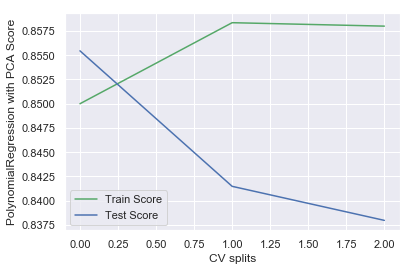

In [156]:
plt.plot(train_score_list, c = 'g', label = 'Train Score')
plt.plot(test_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel(regressor_name+' Score')

Text(0, 0.5, 'PolynomialRegression with PCA RMSE')

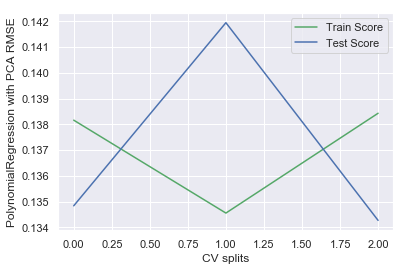

In [157]:
plt.plot(train_rmse_score_list, c = 'g', label = 'Train Score')
plt.plot(test_rmse_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel(regressor_name+' RMSE')

# KNN Regressor

In [158]:
parameters = [{'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}]

grid_search = GridSearchCV(estimator = KNeighborsRegressor(), param_grid = parameters, cv=KFold(3, random_state = 0), n_jobs = -1, return_train_score=True)

grid_search = grid_search.fit(X,y)

print("Grid search best score:", grid_search.best_score_)
print("Grid search best parameters:", grid_search.best_params_)

Grid search best score: 0.7365777185816937
Grid search best parameters: {'n_neighbors': 9}


In [159]:
regressor_name = "kNN Regression with PCA"

train_score_list = []
test_score_list = []
train_rmse_score_list = []
test_rmse_score_list = []

avg_train_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_train_score']
avg_test_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_test_score']

train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_train_score'])

test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_test_score'])    

for train, test in grid_search.cv.split(X):
    train_rmse_score_list.append(np.sqrt(mean_squared_error(y.iloc[train], grid_search.best_estimator_.predict(X[train]))))
    test_rmse_score_list.append(np.sqrt(mean_squared_error(y.iloc[test], grid_search.best_estimator_.predict(X[test]))))

print("3 Fold Train score for",regressor_name,":", train_score_list)
print("3 Fold Test score for",regressor_name,":", test_score_list)
print()
print("Average training score for",regressor_name,"using cross validation:", avg_train_score)
print("Average testing score for",regressor_name,"using cross validation:", avg_test_score)
print()
print("Average training RMSE for",regressor_name,"using cross validation:", sum(train_rmse_score_list) / 3)
print("Average testing RMSE for",regressor_name,"using cross validation:", sum(test_rmse_score_list) / 3)

pca_report_df = pca_report_df.append({"Regressor":regressor_name, "Avg Train Score":avg_train_score, 
                              "Avg Test Score":avg_test_score, "Avg Train RMSE":sum(train_rmse_score_list) / 3,
                              "Avg Test RMSE":sum(test_rmse_score_list) / 3,
                              "Best Hyperparameters" : grid_search.best_params_}, ignore_index=True)

3 Fold Train score for kNN Regression with PCA : [0.7853664500198775, 0.7931342090141833, 0.7981173124516411]
3 Fold Test score for kNN Regression with PCA : [0.7330326552627116, 0.7362991262469614, 0.7404152221389979]

Average training score for kNN Regression with PCA using cross validation: 0.7922059904952339
Average testing score for kNN Regression with PCA using cross validation: 0.7365777185816937

Average training RMSE for kNN Regression with PCA using cross validation: 0.16004333333664567
Average testing RMSE for kNN Regression with PCA using cross validation: 0.15986642635009238


Text(0, 0.5, 'kNN Regression with PCA Score')

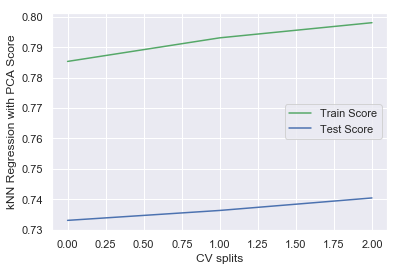

In [160]:
plt.plot(train_score_list, c = 'g', label = 'Train Score')
plt.plot(test_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel(regressor_name+' Score')

Text(0, 0.5, 'kNN Regression with PCA RMSE')

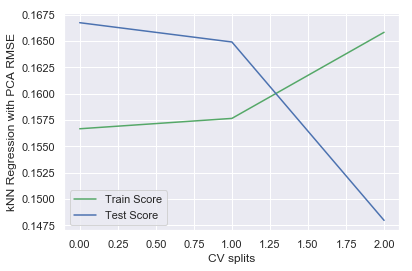

In [161]:
plt.plot(train_rmse_score_list, c = 'g', label = 'Train Score')
plt.plot(test_rmse_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel(regressor_name+' RMSE')

# LinearSVR Regression

In [162]:
parameters = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
             'fit_intercept' : [True, False], 'max_iter' : [1000, 2000, 3000, 4000, 5000, 6000],
             'loss' : ['epsilon_insensitive', 'squared_epsilon_insensitive'], "epsilon" : [0, 0.1, 0.5, 0.7, 1, 10]}

grid_search = GridSearchCV(estimator = LinearSVR(), param_grid = parameters, cv=KFold(3, random_state = 0), n_jobs = -1, return_train_score=True)

grid_search = grid_search.fit(X_org, y)

print("Grid search best score:", grid_search.best_score_)
print("Grid search best parameters:", grid_search.best_params_)

Grid search best score: 0.823050009047482
Grid search best parameters: {'C': 10, 'epsilon': 0, 'fit_intercept': True, 'loss': 'squared_epsilon_insensitive', 'max_iter': 1000}


In [163]:
regressor_name = "LinearSVR with PCA"

train_score_list = []
test_score_list = []
train_rmse_score_list = []
test_rmse_score_list = []

avg_train_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_train_score']
avg_test_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_test_score']

train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_train_score'])

test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_test_score'])    

for train, test in grid_search.cv.split(X_org):
    train_rmse_score_list.append(np.sqrt(mean_squared_error(df[target].iloc[train], grid_search.best_estimator_.predict(X_org[train]))))
    test_rmse_score_list.append(np.sqrt(mean_squared_error(df[target].iloc[test], grid_search.best_estimator_.predict(X_org[test]))))

print("3 Fold Train score for",regressor_name,":", train_score_list)
print("3 Fold Test score for",regressor_name,":", test_score_list)
print()
print("Average training score for",regressor_name,"using cross validation:", avg_train_score)
print("Average testing score for",regressor_name,"using cross validation:", avg_test_score)
print()
print("Average training RMSE for",regressor_name,"using cross validation:", sum(train_rmse_score_list) / 3)
print("Average testing RMSE for",regressor_name,"using cross validation:", sum(test_rmse_score_list) / 3)

pca_report_df = pca_report_df.append({"Regressor":regressor_name, "Avg Train Score":avg_train_score, 
                              "Avg Test Score":avg_test_score, "Avg Train RMSE":sum(train_rmse_score_list) / 3,
                              "Avg Test RMSE":sum(test_rmse_score_list) / 3,
                              "Best Hyperparameters" : grid_search.best_params_}, ignore_index=True)

3 Fold Train score for LinearSVR with PCA : [0.8230971076722151, 0.8457678777466016, 0.8421667619300728]
3 Fold Test score for LinearSVR with PCA : [0.8191266594917753, 0.8327833665938028, 0.8172553266410699]

Average training score for LinearSVR with PCA using cross validation: 0.8370105824496298
Average testing score for LinearSVR with PCA using cross validation: 0.823050009047482

Average training RMSE for LinearSVR with PCA using cross validation: 0.16448899793978303
Average testing RMSE for LinearSVR with PCA using cross validation: 0.1644688205891783


Text(0, 0.5, 'LinearSVR with PCA Score')

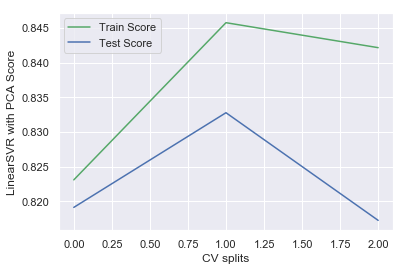

In [164]:
plt.plot(train_score_list, c = 'g', label = 'Train Score')
plt.plot(test_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel(regressor_name+' Score')

Text(0, 0.5, 'LinearSVR with PCA RMSE')

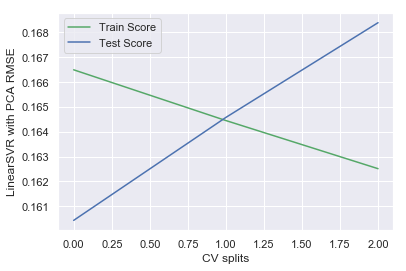

In [165]:
plt.plot(train_rmse_score_list, c = 'g', label = 'Train Score')
plt.plot(test_rmse_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel(regressor_name+' RMSE')

# Kernalized SVR Regression

In [166]:
parameters = [{'C':[0.001, 0.01, 0.1, 1, 10, 100], 'kernel':['rbf','linear','poly'], 'gamma':[0.001, 0.01, 0.1, 1, 10, 100]}]

grid_search = GridSearchCV(estimator = SVR(), param_grid = parameters, cv=KFold(3, random_state = 0), n_jobs = -1, return_train_score=True)

grid_search = grid_search.fit(X,y)

print("Grid search best score:", grid_search.best_score_)
print("Grid search best parameters:", grid_search.best_params_)

Grid search best score: 0.8835602958347654
Grid search best parameters: {'C': 0.001, 'gamma': 0.001, 'kernel': 'linear'}


In [167]:
regressor_name = "KernalizedSVR with PCA"

train_score_list = []
test_score_list = []
train_rmse_score_list = []
test_rmse_score_list = []

avg_train_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_train_score']
avg_test_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_test_score']

train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_train_score'])

test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_test_score'])    

for train, test in grid_search.cv.split(X):
    train_rmse_score_list.append(np.sqrt(mean_squared_error(y.iloc[train], grid_search.best_estimator_.predict(X[train]))))
    test_rmse_score_list.append(np.sqrt(mean_squared_error(y.iloc[test], grid_search.best_estimator_.predict(X[test]))))

print("3 Fold Train score for",regressor_name,":", train_score_list)
print("3 Fold Test score for",regressor_name,":", test_score_list)
print()
print("Average training score for",regressor_name,"using cross validation:", avg_train_score)
print("Average testing score for",regressor_name,"using cross validation:", avg_test_score)
print()
print("Average training RMSE for",regressor_name,"using cross validation:", sum(train_rmse_score_list) / 3)
print("Average testing RMSE for",regressor_name,"using cross validation:", sum(test_rmse_score_list) / 3)

pca_report_df = pca_report_df.append({"Regressor":regressor_name, "Avg Train Score":avg_train_score, 
                              "Avg Test Score":avg_test_score, "Avg Train RMSE":sum(train_rmse_score_list) / 3,
                              "Avg Test RMSE":sum(test_rmse_score_list) / 3,
                              "Best Hyperparameters" : grid_search.best_params_}, ignore_index=True)

3 Fold Train score for KernalizedSVR with PCA : [0.9014473683953809, 0.9142707552164556, 0.9159253119452265]
3 Fold Test score for KernalizedSVR with PCA : [0.8946748462151949, 0.8777770011632804, 0.8781856239133973]

Average training score for KernalizedSVR with PCA using cross validation: 0.9105478118523543
Average testing score for KernalizedSVR with PCA using cross validation: 0.8835602958347654

Average training RMSE for KernalizedSVR with PCA using cross validation: 0.10667452922763765
Average testing RMSE for KernalizedSVR with PCA using cross validation: 0.10650363432104565


Text(0, 0.5, 'KernalizedSVR with PCA Score')

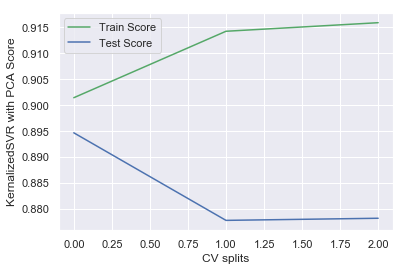

In [168]:
plt.plot(train_score_list, c = 'g', label = 'Train Score')
plt.plot(test_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel(regressor_name+' Score')

Text(0, 0.5, 'KernalizedSVR with PCA RMSE')

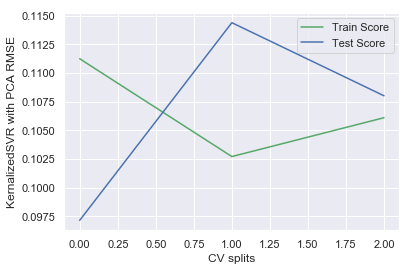

In [169]:
plt.plot(train_rmse_score_list, c = 'g', label = 'Train Score')
plt.plot(test_rmse_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel(regressor_name+' RMSE')

# DecisionTree Regression

In [172]:
parameters = [{'max_depth':np.arange(1, 21), 'min_samples_leaf':[1, 5, 10, 15, 20, 25, 50, 100],
              'min_samples_split':[10, 20, 30, 50, 70, 100], 'max_features' : [None, 1, 2, 3, 10, 18]}] #10, 30, 50, 70, 100, 120, 142

grid_search = GridSearchCV(estimator = DecisionTreeRegressor(), param_grid = parameters, cv=KFold(3, random_state = 0), n_jobs = -1, return_train_score=True)

grid_search = grid_search.fit(X_org, y)

print("Grid search best score:", grid_search.best_score_)
print("Grid search best parameters:", grid_search.best_params_)

Grid search best score: 0.6095651858386208
Grid search best parameters: {'max_depth': 8, 'max_features': 10, 'min_samples_leaf': 10, 'min_samples_split': 30}


In [173]:
regressor_name = "DecisionTree with PCA"

train_score_list = []
test_score_list = []
train_rmse_score_list = []
test_rmse_score_list = []

avg_train_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_train_score']
avg_test_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_test_score']

train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_train_score'])

test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_test_score'])    

for train, test in grid_search.cv.split(X_org):
    train_rmse_score_list.append(np.sqrt(mean_squared_error(df[target].iloc[train], grid_search.best_estimator_.predict(X_org[train]))))
    test_rmse_score_list.append(np.sqrt(mean_squared_error(df[target].iloc[test], grid_search.best_estimator_.predict(X_org[test]))))

print("3 Fold Train score for",regressor_name,":", train_score_list)
print("3 Fold Test score for",regressor_name,":", test_score_list)
print()
print("Average training score for",regressor_name,"using cross validation:", avg_train_score)
print("Average testing score for",regressor_name,"using cross validation:", avg_test_score)
print()
print("Average training RMSE for",regressor_name,"using cross validation:", sum(train_rmse_score_list) / 3)
print("Average testing RMSE for",regressor_name,"using cross validation:", sum(test_rmse_score_list) / 3)

pca_report_df = pca_report_df.append({"Regressor":regressor_name, "Avg Train Score":avg_train_score, 
                              "Avg Test Score":avg_test_score, "Avg Train RMSE":sum(train_rmse_score_list) / 3,
                              "Avg Test RMSE":sum(test_rmse_score_list) / 3,
                              "Best Hyperparameters" : grid_search.best_params_}, ignore_index=True)

3 Fold Train score for DecisionTree with PCA : [0.7646845616882718, 0.7680486167655485, 0.7426583382756924]
3 Fold Test score for DecisionTree with PCA : [0.655937766277402, 0.648034078853722, 0.5245425694923997]

Average training score for DecisionTree with PCA using cross validation: 0.7584638389098375
Average testing score for DecisionTree with PCA using cross validation: 0.6095651858386208

Average training RMSE for DecisionTree with PCA using cross validation: 0.15799151651151414
Average testing RMSE for DecisionTree with PCA using cross validation: 0.15790096058756686


Text(0, 0.5, 'DecisionTree with PCA Score')

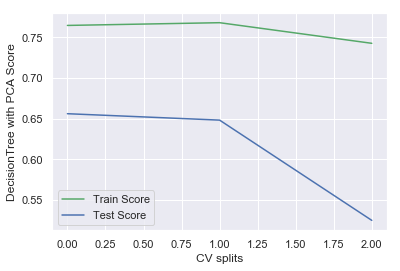

In [175]:
plt.plot(train_score_list, c = 'g', label = 'Train Score')
plt.plot(test_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel(regressor_name+' Score')

Text(0, 0.5, 'DecisionTree with PCA RMSE')

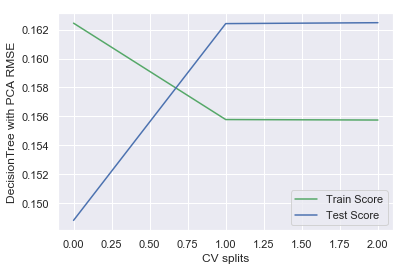

In [174]:
plt.plot(train_rmse_score_list, c = 'g', label = 'Train Score')
plt.plot(test_rmse_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel(regressor_name+' RMSE')

# SGD Regression

In [176]:
parameters = [{'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
                'penalty': ['l2', 'l1', 'elasticnet'],
                'learning_rate': ['constant', 'optimal', 'invscaling']}]

grid_search = GridSearchCV(estimator = SGDRegressor(), param_grid = parameters, cv=KFold(3, random_state = 0), n_jobs = -1, return_train_score=True)

grid_search = grid_search.fit(X,y)

print("Grid search best score:", grid_search.best_score_)
print("Grid search best parameters:", grid_search.best_params_)

Grid search best score: 0.8745634044303648
Grid search best parameters: {'alpha': 1, 'learning_rate': 'invscaling', 'penalty': 'l2'}


In [177]:
regressor_name = "StochasticGradientDecent With PCA"

train_score_list = []
test_score_list = []
train_rmse_score_list = []
test_rmse_score_list = []

avg_train_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_train_score']
avg_test_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_test_score']

train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_train_score'])

test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_test_score'])    

for train, test in grid_search.cv.split(X):
    train_rmse_score_list.append(np.sqrt(mean_squared_error(y.iloc[train], grid_search.best_estimator_.predict(X[train]))))
    test_rmse_score_list.append(np.sqrt(mean_squared_error(y.iloc[test], grid_search.best_estimator_.predict(X[test]))))

print("3 Fold Train score for",regressor_name,":", train_score_list)
print("3 Fold Test score for",regressor_name,":", test_score_list)
print()
print("Average training score for",regressor_name,"using cross validation:", avg_train_score)
print("Average testing score for",regressor_name,"using cross validation:", avg_test_score)
print()
print("Average training RMSE for",regressor_name,"using cross validation:", sum(train_rmse_score_list) / 3)
print("Average testing RMSE for",regressor_name,"using cross validation:", sum(test_rmse_score_list) / 3)

pca_report_df = pca_report_df.append({"Regressor":regressor_name, "Avg Train Score":avg_train_score, 
                              "Avg Test Score":avg_test_score, "Avg Train RMSE":sum(train_rmse_score_list) / 3,
                              "Avg Test RMSE":sum(test_rmse_score_list) / 3,
                              "Best Hyperparameters" : grid_search.best_params_}, ignore_index=True)

3 Fold Train score for StochasticGradientDecent With PCA : [0.8950951071972127, 0.9070409607371971, 0.9014140809084413]
3 Fold Test score for StochasticGradientDecent With PCA : [0.8874991208994567, 0.8727782192272677, 0.8633623430219127]

Average training score for StochasticGradientDecent With PCA using cross validation: 0.9011833829476171
Average testing score for StochasticGradientDecent With PCA using cross validation: 0.8745634044303648

Average training RMSE for StochasticGradientDecent With PCA using cross validation: 0.11605766330729494
Average testing RMSE for StochasticGradientDecent With PCA using cross validation: 0.11602329509559423


Text(0, 0.5, 'StochasticGradientDecent With PCA Score')

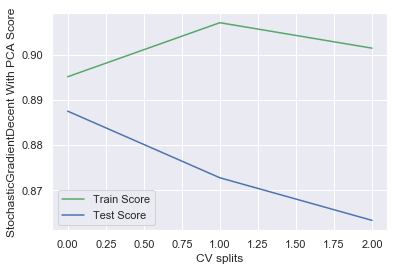

In [178]:
plt.plot(train_score_list, c = 'g', label = 'Train Score')
plt.plot(test_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel(regressor_name+' Score')

Text(0, 0.5, 'StochasticGradientDecent With PCA RMSE')

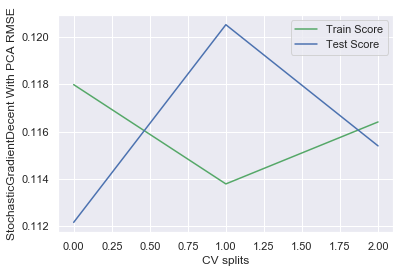

In [179]:
plt.plot(train_rmse_score_list, c = 'g', label = 'Train Score')
plt.plot(test_rmse_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel(regressor_name+' RMSE')

# Neural Networks

In [181]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.metrics import mean_absolute_error

Using TensorFlow backend.


In [182]:
X = MinMaxScaler().fit_transform(df[features])
X = pd.DataFrame(X, index=df[features].index, columns=df[features].columns)
y = df[target]

### DNN Model

In [212]:
def create_model(input_dim):
    NN_model = Sequential()

    # The Input Layer :
    NN_model.add(Dense(64, kernel_initializer='normal', input_dim = input_dim, activation='relu'))

    # The Hidden Layers :
    NN_model.add(Dense(32, kernel_initializer='normal', activation='relu'))
    NN_model.add(Dense(16, kernel_initializer='normal', activation='relu'))

    # The Output Layer :
    NN_model.add(Dense(1, kernel_initializer='normal', activation='linear'))

    # Compile the network :
    NN_model.compile(loss='mse', optimizer='sgd', metrics=['mse'])
    NN_model.summary()
    
    return NN_model

In [213]:
from keras.wrappers.scikit_learn import KerasRegressor
NN_model = KerasRegressor(build_fn = create_model, input_dim = X.shape[1])

parameters = {'batch_size': [10,20,30], 'epochs': [10, 20, 30]}

grid_search = GridSearchCV(estimator = NN_model, param_grid = parameters, scoring = "r2", cv=KFold(3, random_state = 0), n_jobs = 1, return_train_score=True)

grid_search = grid_search.fit(X,y)

print("Grid search best score:", grid_search.best_score_)
print("Grid search best parameters:", grid_search.best_params_)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_637 (Dense)            (None, 64)                9152      
_________________________________________________________________
dense_638 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_639 (Dense)            (None, 16)                528       
_________________________________________________________________
dense_640 (Dense)            (None, 1)                 17        
Total params: 11,777
Trainable params: 11,777
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
512/512 [==============================] - 4s 8ms/step - loss: 32.1574 - mean_squared_error: 32.1574
Epoch 2/10
512/512 [==============================] - 0s 403us/step - loss: 0.2608 - mean_squared_error: 0.2608
Epoch 3/10
512/512 [==========================

512/512 [==============================] - 0s 429us/step - loss: 0.0271 - mean_squared_error: 0.0271
Epoch 13/20
512/512 [==============================] - 0s 413us/step - loss: 0.0355 - mean_squared_error: 0.0355
Epoch 14/20
512/512 [==============================] - 0s 397us/step - loss: 0.0236 - mean_squared_error: 0.0236
Epoch 15/20
512/512 [==============================] - 0s 413us/step - loss: 0.0177 - mean_squared_error: 0.0177
Epoch 16/20
512/512 [==============================] - 0s 403us/step - loss: 0.0265 - mean_squared_error: 0.0265
Epoch 17/20
512/512 [==============================] - 0s 403us/step - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 18/20
512/512 [==============================] - 0s 395us/step - loss: 0.0277 - mean_squared_error: 0.0277
Epoch 19/20
512/512 [==============================] - 0s 409us/step - loss: 0.0180 - mean_squared_error: 0.0180
Epoch 20/20
512/512 [==============================] - 0s 403us/step - loss: 0.0199 - mean_squared_error: 0.

512/512 [==============================] - 4s 8ms/step - loss: 37.3360 - mean_squared_error: 37.3360
Epoch 2/30
512/512 [==============================] - 0s 423us/step - loss: 0.6054 - mean_squared_error: 0.6054
Epoch 3/30
512/512 [==============================] - 0s 421us/step - loss: 0.1295 - mean_squared_error: 0.1295
Epoch 4/30
512/512 [==============================] - 0s 421us/step - loss: 0.0653 - mean_squared_error: 0.0653
Epoch 5/30
512/512 [==============================] - 0s 436us/step - loss: 0.0618 - mean_squared_error: 0.0618
Epoch 6/30
512/512 [==============================] - 0s 409us/step - loss: 0.0626 - mean_squared_error: 0.0626
Epoch 7/30
512/512 [==============================] - 0s 419us/step - loss: 0.0695 - mean_squared_error: 0.0695
Epoch 8/30
512/512 [==============================] - 0s 427us/step - loss: 0.0353 - mean_squared_error: 0.0353
Epoch 9/30
512/512 [==============================] - 0s 432us/step - loss: 0.0449 - mean_squared_error: 0.0449
Epo

513/513 [==============================] - 4s 8ms/step - loss: 33.1191 - mean_squared_error: 33.1191
Epoch 2/30
513/513 [==============================] - 0s 537us/step - loss: 0.4877 - mean_squared_error: 0.4877
Epoch 3/30
513/513 [==============================] - 0s 486us/step - loss: 0.1033 - mean_squared_error: 0.1033
Epoch 4/30
513/513 [==============================] - 0s 437us/step - loss: 0.0518 - mean_squared_error: 0.0518
Epoch 5/30
513/513 [==============================] - 0s 505us/step - loss: 0.0499 - mean_squared_error: 0.0499
Epoch 6/30
513/513 [==============================] - 0s 420us/step - loss: 0.0449 - mean_squared_error: 0.0449
Epoch 7/30
513/513 [==============================] - 0s 439us/step - loss: 0.0514 - mean_squared_error: 0.0514
Epoch 8/30
513/513 [==============================] - 0s 435us/step - loss: 0.0299 - mean_squared_error: 0.0299
Epoch 9/30
513/513 [==============================] - 0s 502us/step - loss: 0.0230 - mean_squared_error: 0.0230
Epo

513/513 [==============================] - 4s 8ms/step - loss: 74.5334 - mean_squared_error: 74.5334
Epoch 2/10
513/513 [==============================] - 0s 210us/step - loss: 4.7485 - mean_squared_error: 4.7485
Epoch 3/10
513/513 [==============================] - 0s 220us/step - loss: 1.3506 - mean_squared_error: 1.3506
Epoch 4/10
513/513 [==============================] - 0s 253us/step - loss: 0.3696 - mean_squared_error: 0.3696
Epoch 5/10
513/513 [==============================] - 0s 227us/step - loss: 0.1059 - mean_squared_error: 0.1059
Epoch 6/10
513/513 [==============================] - 0s 222us/step - loss: 0.1248 - mean_squared_error: 0.1248
Epoch 7/10
513/513 [==============================] - 0s 224us/step - loss: 0.0430 - mean_squared_error: 0.0430
Epoch 8/10
513/513 [==============================] - 0s 222us/step - loss: 0.0461 - mean_squared_error: 0.0461
Epoch 9/10
513/513 [==============================] - 0s 220us/step - loss: 0.0492 - mean_squared_error: 0.0492
Epo

513/513 [==============================] - 5s 9ms/step - loss: 70.1478 - mean_squared_error: 70.1478
Epoch 2/20
513/513 [==============================] - 0s 264us/step - loss: 2.2626 - mean_squared_error: 2.2626
Epoch 3/20
513/513 [==============================] - 0s 276us/step - loss: 0.6021 - mean_squared_error: 0.6021
Epoch 4/20
513/513 [==============================] - 0s 261us/step - loss: 0.0779 - mean_squared_error: 0.0779
Epoch 5/20
513/513 [==============================] - 0s 267us/step - loss: 0.0747 - mean_squared_error: 0.0747
Epoch 6/20
513/513 [==============================] - 0s 267us/step - loss: 0.0777 - mean_squared_error: 0.0777
Epoch 7/20
513/513 [==============================] - 0s 259us/step - loss: 0.0411 - mean_squared_error: 0.0411
Epoch 8/20
513/513 [==============================] - 0s 257us/step - loss: 0.0419 - mean_squared_error: 0.0419
Epoch 9/20
513/513 [==============================] - 0s 272us/step - loss: 0.0377 - mean_squared_error: 0.0377
Epo

513/513 [==============================] - 0s 313us/step - loss: 0.0285 - mean_squared_error: 0.0285
Epoch 9/30
513/513 [==============================] - 0s 300us/step - loss: 0.0320 - mean_squared_error: 0.0320
Epoch 10/30
513/513 [==============================] - 0s 286us/step - loss: 0.0439 - mean_squared_error: 0.0439
Epoch 11/30
513/513 [==============================] - 0s 300us/step - loss: 0.0501 - mean_squared_error: 0.0501
Epoch 12/30
513/513 [==============================] - 0s 290us/step - loss: 0.0288 - mean_squared_error: 0.0288
Epoch 13/30
513/513 [==============================] - 0s 270us/step - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 14/30
513/513 [==============================] - 0s 270us/step - loss: 0.0232 - mean_squared_error: 0.0232
Epoch 15/30
513/513 [==============================] - 0s 272us/step - loss: 0.0209 - mean_squared_error: 0.0209
Epoch 16/30
513/513 [==============================] - 0s 274us/step - loss: 0.0200 - mean_squared_error: 0.0

512/512 [==============================] - 0s 166us/step - loss: 0.6258 - mean_squared_error: 0.6258
Epoch 6/10
512/512 [==============================] - 0s 175us/step - loss: 0.2222 - mean_squared_error: 0.2222
Epoch 7/10
512/512 [==============================] - 0s 179us/step - loss: 0.1631 - mean_squared_error: 0.1631
Epoch 8/10
512/512 [==============================] - 0s 173us/step - loss: 0.1324 - mean_squared_error: 0.1324
Epoch 9/10
512/512 [==============================] - 0s 171us/step - loss: 0.0906 - mean_squared_error: 0.0906
Epoch 10/10
512/512 [==============================] - 0s 171us/step - loss: 0.0376 - mean_squared_error: 0.0376
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_713 (Dense)            (None, 64)                9152      
_________________________________________________________________
dense_714 (Dense)            (None, 32)                2080      
________

513/513 [==============================] - 5s 9ms/step - loss: 95.6986 - mean_squared_error: 95.6986
Epoch 2/20
513/513 [==============================] - 0s 169us/step - loss: 12.8893 - mean_squared_error: 12.8893
Epoch 3/20
513/513 [==============================] - 0s 169us/step - loss: 1.1210 - mean_squared_error: 1.1210
Epoch 4/20
513/513 [==============================] - 0s 171us/step - loss: 0.0875 - mean_squared_error: 0.0875
Epoch 5/20
513/513 [==============================] - 0s 175us/step - loss: 0.0680 - mean_squared_error: 0.0680
Epoch 6/20
513/513 [==============================] - 0s 171us/step - loss: 0.0916 - mean_squared_error: 0.0916
Epoch 7/20
513/513 [==============================] - 0s 185us/step - loss: 0.1279 - mean_squared_error: 0.1279
Epoch 8/20
513/513 [==============================] - 0s 174us/step - loss: 0.0541 - mean_squared_error: 0.0541
Epoch 9/20
513/513 [==============================] - 0s 181us/step - loss: 0.0589 - mean_squared_error: 0.0589
E

512/512 [==============================] - 0s 173us/step - loss: 0.0409 - mean_squared_error: 0.0409
Epoch 19/30
512/512 [==============================] - 0s 169us/step - loss: 0.0359 - mean_squared_error: 0.0359
Epoch 20/30
512/512 [==============================] - 0s 177us/step - loss: 0.0813 - mean_squared_error: 0.0813
Epoch 21/30
512/512 [==============================] - 0s 185us/step - loss: 0.0313 - mean_squared_error: 0.0313
Epoch 22/30
512/512 [==============================] - 0s 183us/step - loss: 0.0274 - mean_squared_error: 0.0274
Epoch 23/30
512/512 [==============================] - 0s 164us/step - loss: 0.0266 - mean_squared_error: 0.0266
Epoch 24/30
512/512 [==============================] - 0s 168us/step - loss: 0.0246 - mean_squared_error: 0.0246
Epoch 25/30
512/512 [==============================] - 0s 171us/step - loss: 0.0258 - mean_squared_error: 0.0258
Epoch 26/30
512/512 [==============================] - 0s 173us/step - loss: 0.0293 - mean_squared_error: 0.

513/513 [==============================] - 0s 169us/step - loss: 0.0291 - mean_squared_error: 0.0291
Epoch 16/30
513/513 [==============================] - 0s 175us/step - loss: 0.0275 - mean_squared_error: 0.0275
Epoch 17/30
513/513 [==============================] - 0s 167us/step - loss: 0.0469 - mean_squared_error: 0.0469
Epoch 18/30
513/513 [==============================] - 0s 179us/step - loss: 0.0371 - mean_squared_error: 0.0371
Epoch 19/30
513/513 [==============================] - 0s 174us/step - loss: 0.0387 - mean_squared_error: 0.0387
Epoch 20/30
513/513 [==============================] - 0s 173us/step - loss: 0.0234 - mean_squared_error: 0.0234
Epoch 21/30
513/513 [==============================] - 0s 168us/step - loss: 0.0355 - mean_squared_error: 0.0355
Epoch 22/30
513/513 [==============================] - 0s 179us/step - loss: 0.0243 - mean_squared_error: 0.0243
Epoch 23/30
513/513 [==============================] - 0s 169us/step - loss: 0.0292 - mean_squared_error: 0.

In [191]:
regressor_name = "DNN Regression"

train_score_list = []
test_score_list = []
train_rmse_score_list = []
test_rmse_score_list = []

avg_train_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_train_score']
avg_test_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_test_score']

train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_train_score'])

test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_test_score'])    

for train, test in grid_search.cv.split(X):
    train_rmse_score_list.append(np.sqrt(mean_squared_error(y.iloc[train], grid_search.best_estimator_.predict(X.iloc[train]))))
    test_rmse_score_list.append(np.sqrt(mean_squared_error(y.iloc[test], grid_search.best_estimator_.predict(X.iloc[test]))))

print("3 Fold Train score for",regressor_name,":", train_score_list)
print("3 Fold Test score for",regressor_name,":", test_score_list)
print()
print("Average training score for",regressor_name,"using cross validation:", avg_train_score)
print("Average testing score for",regressor_name,"using cross validation:", avg_test_score)
print()
print("Average training RMSE for",regressor_name,"using cross validation:", sum(train_rmse_score_list) / 3)
print("Average testing RMSE for",regressor_name,"using cross validation:", sum(test_rmse_score_list) / 3)

nn_report_df = nn_report_df.append({"Regressor":regressor_name, "Avg Train Score":avg_train_score, 
                              "Avg Test Score":avg_test_score, "Avg Train RMSE":sum(train_rmse_score_list) / 3,
                              "Avg Test RMSE":sum(test_rmse_score_list) / 3,
                              "Best Hyperparameters" : grid_search.best_params_}, ignore_index=True)

3 Fold Train score for DNN Regression : [0.8838404247987511, 0.8685784622104296, 0.8460601439416205]
3 Fold Test score for DNN Regression : [0.8777923071942947, 0.8387569104595282, 0.8339511869612738]

Average training score for DNN Regression using cross validation: 0.8661596769836004
Average testing score for DNN Regression using cross validation: 0.8502027254728987

Average training RMSE for DNN Regression using cross validation: 0.11127960671754533
Average testing RMSE for DNN Regression using cross validation: 0.11122816456569273


Text(0, 0.5, 'DNN Regression Score')

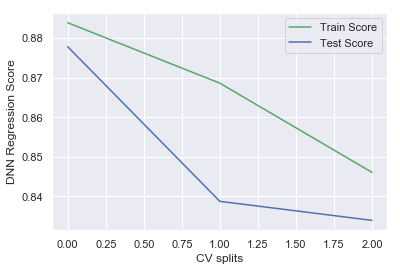

In [192]:
plt.plot(train_score_list, c = 'g', label = 'Train Score')
plt.plot(test_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel(regressor_name+' Score')

Text(0, 0.5, 'DNN Regression  RMSE')

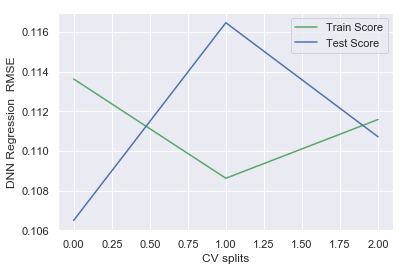

In [193]:
plt.plot(train_rmse_score_list, c = 'g', label = 'Train Score')
plt.plot(test_rmse_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel(regressor_name+'  RMSE')

### Perceptron Model

In [215]:
def create_model(input_dim):
    NN_model = Sequential()

    # The Input Layer :
    NN_model.add(Dense(64, kernel_initializer='normal', input_dim = input_dim, activation='relu'))

    # The Output Layer :
    NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

    # Compile the network :
    NN_model.compile(loss='mse', optimizer='sgd', metrics=['mse'])
    NN_model.summary()
    
    return NN_model

In [216]:
from keras.wrappers.scikit_learn import KerasRegressor
NN_model = KerasRegressor(build_fn = create_model, input_dim = X.shape[1])

parameters = {'batch_size': [10,20,30], 'epochs': [10, 20, 30]}

grid_search = GridSearchCV(estimator = NN_model, param_grid = parameters, scoring = "r2", cv=KFold(3, random_state = 0), n_jobs = 1, return_train_score=True)

grid_search = grid_search.fit(X,y)

print("Grid search best score:", grid_search.best_score_)
print("Grid search best parameters:", grid_search.best_params_)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_749 (Dense)            (None, 64)                9152      
_________________________________________________________________
dense_750 (Dense)            (None, 1)                 65        
Total params: 9,217
Trainable params: 9,217
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
512/512 [==============================] - 5s 10ms/step - loss: 8.6105 - mean_squared_error: 8.6105
Epoch 2/10
512/512 [==============================] - 0s 521us/step - loss: 0.4962 - mean_squared_error: 0.4962
Epoch 3/10
512/512 [==============================] - 0s 501us/step - loss: 0.2992 - mean_squared_error: 0.2992
Epoch 4/10
512/512 [==============================] - 0s 510us/step - loss: 0.2848 - mean_squared_error: 0.2848
Epoch 5/10
512/512 [==============================] - 0s 505us/step - loss: 0.3150 - mean

513/513 [==============================] - 5s 10ms/step - loss: 8.7356 - mean_squared_error: 8.7356
Epoch 2/20
513/513 [==============================] - 0s 595us/step - loss: 0.4879 - mean_squared_error: 0.4879
Epoch 3/20
513/513 [==============================] - 0s 570us/step - loss: 0.3959 - mean_squared_error: 0.3959
Epoch 4/20
513/513 [==============================] - 0s 557us/step - loss: 0.3004 - mean_squared_error: 0.3004
Epoch 5/20
513/513 [==============================] - 0s 574us/step - loss: 0.4004 - mean_squared_error: 0.4004
Epoch 6/20
513/513 [==============================] - 0s 609us/step - loss: 0.3378 - mean_squared_error: 0.3378
Epoch 7/20
513/513 [==============================] - 0s 581us/step - loss: 0.1987 - mean_squared_error: 0.1987
Epoch 8/20
513/513 [==============================] - 0s 579us/step - loss: 0.1723 - mean_squared_error: 0.1723
Epoch 9/20
513/513 [==============================] - 0s 577us/step - loss: 0.1839 - mean_squared_error: 0.1839
Epoc

512/512 [==============================] - 0s 551us/step - loss: 0.1196 - mean_squared_error: 0.1196
Epoch 24/30
512/512 [==============================] - 0s 543us/step - loss: 0.1447 - mean_squared_error: 0.1447
Epoch 25/30
512/512 [==============================] - 0s 542us/step - loss: 0.1078 - mean_squared_error: 0.1078
Epoch 26/30
512/512 [==============================] - 0s 530us/step - loss: 0.1577 - mean_squared_error: 0.1577
Epoch 27/30
512/512 [==============================] - 0s 534us/step - loss: 0.1457 - mean_squared_error: 0.1457
Epoch 28/30
512/512 [==============================] - 0s 554us/step - loss: 0.1682 - mean_squared_error: 0.1682
Epoch 29/30
512/512 [==============================] - 0s 522us/step - loss: 0.1263 - mean_squared_error: 0.1263
Epoch 30/30
512/512 [==============================] - 0s 517us/step - loss: 0.1202 - mean_squared_error: 0.1202
_________________________________________________________________
Layer (type)                 Output Shape 

513/513 [==============================] - 0s 521us/step - loss: 0.1561 - mean_squared_error: 0.1561
Epoch 26/30
513/513 [==============================] - 0s 509us/step - loss: 0.0873 - mean_squared_error: 0.0873
Epoch 27/30
513/513 [==============================] - 0s 508us/step - loss: 0.1496 - mean_squared_error: 0.1496
Epoch 28/30
513/513 [==============================] - 0s 593us/step - loss: 0.1114 - mean_squared_error: 0.1114
Epoch 29/30
513/513 [==============================] - 0s 493us/step - loss: 0.1034 - mean_squared_error: 0.1034
Epoch 30/30
513/513 [==============================] - 0s 465us/step - loss: 0.1104 - mean_squared_error: 0.1104
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_767 (Dense)            (None, 64)                9152      
_________________________________________________________________
dense_768 (Dense)            (None, 1)                 65        
Tota

512/512 [==============================] - 0s 255us/step - loss: 0.1378 - mean_squared_error: 0.1378
Epoch 17/20
512/512 [==============================] - 0s 247us/step - loss: 0.1739 - mean_squared_error: 0.1739
Epoch 18/20
512/512 [==============================] - 0s 243us/step - loss: 0.2073 - mean_squared_error: 0.2073
Epoch 19/20
512/512 [==============================] - 0s 255us/step - loss: 0.1687 - mean_squared_error: 0.1687
Epoch 20/20
512/512 [==============================] - 0s 251us/step - loss: 0.1348 - mean_squared_error: 0.1348
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_775 (Dense)            (None, 64)                9152      
_________________________________________________________________
dense_776 (Dense)            (None, 1)                 65        
Total params: 9,217
Trainable params: 9,217
Non-trainable params: 0
_________________________________________________

Epoch 13/30
512/512 [==============================] - 0s 263us/step - loss: 0.2091 - mean_squared_error: 0.2091
Epoch 14/30
512/512 [==============================] - 0s 257us/step - loss: 0.2121 - mean_squared_error: 0.2121
Epoch 15/30
512/512 [==============================] - 0s 267us/step - loss: 0.4143 - mean_squared_error: 0.4143
Epoch 16/30
512/512 [==============================] - 0s 259us/step - loss: 0.1681 - mean_squared_error: 0.1681
Epoch 17/30
512/512 [==============================] - 0s 288us/step - loss: 0.2030 - mean_squared_error: 0.2030
Epoch 18/30
512/512 [==============================] - 0s 323us/step - loss: 0.2054 - mean_squared_error: 0.2054
Epoch 19/30
512/512 [==============================] - 0s 284us/step - loss: 0.1702 - mean_squared_error: 0.1702
Epoch 20/30
512/512 [==============================] - 0s 339us/step - loss: 0.1201 - mean_squared_error: 0.1201
Epoch 21/30
512/512 [==============================] - 0s 269us/step - loss: 0.2234 - mean_squar

513/513 [==============================] - 0s 253us/step - loss: 0.1720 - mean_squared_error: 0.1720
Epoch 16/30
513/513 [==============================] - 0s 245us/step - loss: 0.1784 - mean_squared_error: 0.1784
Epoch 17/30
513/513 [==============================] - 0s 245us/step - loss: 0.1399 - mean_squared_error: 0.1399
Epoch 18/30
513/513 [==============================] - 0s 259us/step - loss: 0.1658 - mean_squared_error: 0.1658
Epoch 19/30
513/513 [==============================] - 0s 247us/step - loss: 0.1440 - mean_squared_error: 0.1440
Epoch 20/30
513/513 [==============================] - 0s 247us/step - loss: 0.1673 - mean_squared_error: 0.1673
Epoch 21/30
513/513 [==============================] - 0s 249us/step - loss: 0.1355 - mean_squared_error: 0.1355
Epoch 22/30
513/513 [==============================] - 0s 245us/step - loss: 0.2026 - mean_squared_error: 0.2026
Epoch 23/30
513/513 [==============================] - 0s 247us/step - loss: 0.2101 - mean_squared_error: 0.

512/512 [==============================] - 0s 191us/step - loss: 0.5110 - mean_squared_error: 0.5110
Epoch 7/20
512/512 [==============================] - 0s 193us/step - loss: 0.2704 - mean_squared_error: 0.2704
Epoch 8/20
512/512 [==============================] - 0s 181us/step - loss: 0.4746 - mean_squared_error: 0.4746
Epoch 9/20
512/512 [==============================] - 0s 185us/step - loss: 0.2331 - mean_squared_error: 0.2331
Epoch 10/20
512/512 [==============================] - 0s 181us/step - loss: 0.2061 - mean_squared_error: 0.2061
Epoch 11/20
512/512 [==============================] - 0s 189us/step - loss: 0.2408 - mean_squared_error: 0.2408
Epoch 12/20
512/512 [==============================] - 0s 175us/step - loss: 0.1884 - mean_squared_error: 0.1884
Epoch 13/20
512/512 [==============================] - 0s 179us/step - loss: 0.1619 - mean_squared_error: 0.1619
Epoch 14/20
512/512 [==============================] - 0s 185us/step - loss: 0.2230 - mean_squared_error: 0.223

Epoch 3/30
512/512 [==============================] - 0s 205us/step - loss: 0.4688 - mean_squared_error: 0.4688
Epoch 4/30
512/512 [==============================] - 0s 191us/step - loss: 0.5234 - mean_squared_error: 0.5234
Epoch 5/30
512/512 [==============================] - 0s 210us/step - loss: 0.5237 - mean_squared_error: 0.5237
Epoch 6/30
512/512 [==============================] - 0s 230us/step - loss: 0.2918 - mean_squared_error: 0.2918
Epoch 7/30
512/512 [==============================] - 0s 232us/step - loss: 0.4203 - mean_squared_error: 0.4203
Epoch 8/30
512/512 [==============================] - 0s 245us/step - loss: 0.3911 - mean_squared_error: 0.3911
Epoch 9/30
512/512 [==============================] - 0s 220us/step - loss: 0.2407 - mean_squared_error: 0.2407
Epoch 10/30
512/512 [==============================] - 0s 203us/step - loss: 0.3571 - mean_squared_error: 0.3571
Epoch 11/30
512/512 [==============================] - 0s 193us/step - loss: 0.3517 - mean_squared_erro

513/513 [==============================] - 0s 233us/step - loss: 0.4287 - mean_squared_error: 0.4287
Epoch 6/30
513/513 [==============================] - 0s 206us/step - loss: 0.3675 - mean_squared_error: 0.3675
Epoch 7/30
513/513 [==============================] - 0s 189us/step - loss: 0.3055 - mean_squared_error: 0.3055
Epoch 8/30
513/513 [==============================] - 0s 187us/step - loss: 0.2711 - mean_squared_error: 0.2711
Epoch 9/30
513/513 [==============================] - 0s 189us/step - loss: 0.3462 - mean_squared_error: 0.3462
Epoch 10/30
513/513 [==============================] - 0s 202us/step - loss: 0.3730 - mean_squared_error: 0.3730
Epoch 11/30
513/513 [==============================] - 0s 196us/step - loss: 0.2652 - mean_squared_error: 0.2652
Epoch 12/30
513/513 [==============================] - 0s 212us/step - loss: 0.2644 - mean_squared_error: 0.2644
Epoch 13/30
513/513 [==============================] - 0s 194us/step - loss: 0.2020 - mean_squared_error: 0.2020

In [217]:
regressor_name = "Perceptron Model"

train_score_list = []
test_score_list = []
train_rmse_score_list = []
test_rmse_score_list = []

avg_train_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_train_score']
avg_test_score = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['mean_test_score']

train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_train_score'])
train_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_train_score'])

test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split0_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split1_test_score'])
test_score_list.append(pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_].loc['split2_test_score'])    

for train, test in grid_search.cv.split(X):
    train_rmse_score_list.append(np.sqrt(mean_squared_error(y.iloc[train], grid_search.best_estimator_.predict(X.iloc[train]))))
    test_rmse_score_list.append(np.sqrt(mean_squared_error(y.iloc[test], grid_search.best_estimator_.predict(X.iloc[test]))))

print("3 Fold Train score for",regressor_name,":", train_score_list)
print("3 Fold Test score for",regressor_name,":", test_score_list)
print()
print("Average training score for",regressor_name,"using cross validation:", avg_train_score)
print("Average testing score for",regressor_name,"using cross validation:", avg_test_score)
print()
print("Average training RMSE for",regressor_name,"using cross validation:", sum(train_rmse_score_list) / 3)
print("Average testing RMSE for",regressor_name,"using cross validation:", sum(test_rmse_score_list) / 3)

nn_report_df = nn_report_df.append({"Regressor":regressor_name, "Avg Train Score":avg_train_score, 
                              "Avg Test Score":avg_test_score, "Avg Train RMSE":sum(train_rmse_score_list) / 3,
                              "Avg Test RMSE":sum(test_rmse_score_list) / 3,
                              "Best Hyperparameters" : grid_search.best_params_}, ignore_index=True)

3 Fold Train score for Perceptron Model : [0.2670948826282771, 0.36534643947232004, 0.188955569353508]
3 Fold Test score for Perceptron Model : [0.0005667329290452994, 0.051264870657661166, -0.04843116049444163]

Average training score for Perceptron Model using cross validation: 0.27379896381803503
Average testing score for Perceptron Model using cross validation: 0.0011327440371246334

Average training RMSE for Perceptron Model using cross validation: 0.267111920815498
Average testing RMSE for Perceptron Model using cross validation: 0.26701850744985145


Text(0, 0.5, 'Perceptron Model Score')

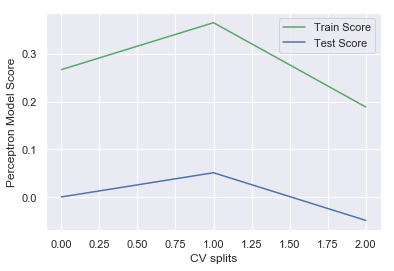

In [218]:
plt.plot(train_score_list, c = 'g', label = 'Train Score')
plt.plot(test_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel(regressor_name+' Score')

Text(0, 0.5, 'Perceptron Model RMSE')

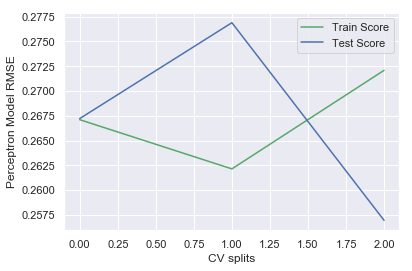

In [219]:
plt.plot(train_rmse_score_list, c = 'g', label = 'Train Score')
plt.plot(test_rmse_score_list, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('CV splits')
plt.ylabel(regressor_name+' RMSE')

In [220]:
pd.options.display.max_colwidth = 500

# Model evaluation strategy and conclusion

Before discussing which evaluation strategy we should choose lets look at what RMSE and R2 score mean .<br /><br />

RMSE - RMSE is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are.<br />

R2 score - R-squared (R2) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model.<br />

We decide our evaluation strategy as RMSE value. The reason for choosing RMSE over R2 is because our target variable is SalePrice & we will always want that to have minimum error in predicting that.<br />

We will choose testing data results to determine best model for the dataset.<br />

## Project 1 model results

KernalizedSVR Regression gave us best result with respect Test RMSE (0.077474).

In [222]:
report_df.sort_values(by=["Avg Test RMSE", "Avg Test Score"], ascending=True)

,Regressor,Avg Train Score,Avg Test Score,Avg Train RMSE,Avg Test RMSE,Best Hyperparameters
6,KernalizedSVR Regression,0.952548,0.892162,0.077578,0.077474,"{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}"
2,LinearRegression,0.952446,0.879072,0.083297,0.083178,"{'fit_intercept': True, 'normalize': False}"
3,PolynomialRegression,0.952446,0.879072,0.083297,0.083178,"{'linearregression__fit_intercept': True, 'linearregression__normalize': False, 'polynomialfeatures__degree': 1}"
1,Ridge,0.945454,0.900227,0.087371,0.087213,{'alpha': 1}
0,Lasso,0.927977,0.905121,0.098875,0.098782,{'alpha': 0.001}
7,DecisionTree Regression,0.894669,0.808840,0.109747,0.109738,"{'max_depth': 14, 'max_features': 100, 'min_samples_leaf': 10, 'min_samples_split': 20}"
8,StochasticGradientDecent Regression,0.844612,0.826166,0.132187,0.132084,"{'alpha': 0.1, 'learning_rate': 'constant', 'penalty': 'l2'}"
5,LinearSVR,0.881656,0.845784,0.133506,0.133391,"{'C': 10, 'epsilon': 0, 'fit_intercept': True, 'loss': 'epsilon_insensitive', 'max_iter': 6000}"
4,kNN Regression,0.817793,0.740793,0.146979,0.146769,{'n_neighbors': 6}


## Project 1 model results after applying PCA

Ridge Regression with PCA gives us best result with respect Test RMSE (0.102482). But it is not the best RMSE as Ridge Regression without using PCA gave us the better RMSE of 0.087213.<br /> Similarly, PCA does not give better results for rest of the models except for StochasticGradientDecent Regression & kNN Regression where PCA helps in reducing the RMSE.

In [224]:
pca_report_df.sort_values(by=["Avg Test RMSE", "Avg Test Score"], ascending=True)

,Regressor,Avg Train Score,Avg Test Score,Avg Train RMSE,Avg Test RMSE,Best Hyperparameters
1,Ridge with PCA,0.922337,0.886727,0.102564,0.102482,{'alpha': 100}
6,KernalizedSVR with PCA,0.910548,0.883560,0.106675,0.106504,"{'C': 0.001, 'gamma': 0.001, 'kernel': 'linear'}"
8,StochasticGradientDecent With PCA,0.901183,0.874563,0.116058,0.116023,"{'alpha': 1, 'learning_rate': 'invscaling', 'penalty': 'l2'}"
0,Lasso with PCA,0.891567,0.871761,0.120958,0.120866,{'alpha': 0.01}
2,LinearRegression with PCA,0.855444,0.844981,0.137047,0.137016,"{'fit_intercept': True, 'normalize': True}"
3,PolynomialRegression with PCA,0.855444,0.844981,0.137047,0.137016,"{'linearregression__fit_intercept': True, 'linearregression__normalize': True, 'polynomialfeatures__degree': 1}"
7,DecisionTree with PCA,0.758464,0.609565,0.157992,0.157901,"{'max_depth': 8, 'max_features': 10, 'min_samples_leaf': 10, 'min_samples_split': 30}"
4,kNN Regression with PCA,0.792206,0.736578,0.160043,0.159866,{'n_neighbors': 9}
5,LinearSVR with PCA,0.837011,0.823050,0.164489,0.164469,"{'C': 10, 'epsilon': 0, 'fit_intercept': True, 'loss': 'squared_epsilon_insensitive', 'max_iter': 1000}"


## Project 2 ensemble model results

GredientBoosting Regression gives us best result with respect Test RMSE (0.050798). Even better than KernalizedSVR in project 1. <br />
For rest of the models ensemble learning decreases RMSE slightly.

In [247]:
new_report_df.sort_values(by=["Avg Test RMSE", "Avg Test Score"], ascending=True)

,Regressor,Avg Train Score,Avg Test Score,Avg Train RMSE,Avg Test RMSE,Best Hyperparameters
4,GredientBoosting Regression,0.988172,0.888795,0.050803,0.050798,"{'learning_rate': 0.1, 'max_depth': 5, 'max_leaf_nodes': 10}"
1,Ridge with AdaBoost boosting,0.948254,0.899567,0.086134,0.085964,"{'learning_rate': 0.01, 'loss': 'exponential'}"
3,PolynomialRegression with Pasting,0.941759,0.882853,0.087894,0.087744,"{'bootstrap': False, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 0.5}"
2,LinearRegression with Pasting,0.943458,0.887693,0.088009,0.087923,"{'bootstrap': False, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 0.5}"
5,DecisionTree with Bagging,0.915579,0.855697,0.102264,0.102262,"{'bootstrap': True, 'bootstrap_features': True, 'max_samples': 1.0, 'oob_score': False}"
6,StochasticGradientDecent with Bagging,0.864547,0.846106,0.136780,0.136655,"{'bootstrap': True, 'bootstrap_features': True, 'max_features': 1.0, 'max_samples': 1.0, 'oob_score': True}"
0,Lasso with Adaboosting,0.931545,0.905822,47.471441,47.470385,"{'learning_rate': 0.01, 'loss': 'exponential'}"


## Project 2 Neural Networks results

We applied 2 types of neural networks viz. Deep Neural model with 2 hidden layers and Perceptron model. DNN clearly works better than perceptron. We can still improve DNN model by adding more layers and tweaking hyper parameters bu due to system constraints we are not doing that in this project.

In [246]:
nn_report_df

,Regressor,Avg Train Score,Avg Test Score,Avg Train RMSE,Avg Test RMSE,Best Hyperparameters
0,DNN Regression,0.866160,0.850203,0.111280,0.111228,"{'batch_size': 10, 'epochs': 30}"
1,Perceptron Model,0.222681,-0.095893,0.279267,0.279098,"{'batch_size': 20, 'epochs': 30}"


## Now lets see which one is the best model out of all models for our dataset as per RMSE.

In [248]:
best_models_df = report_df.sort_values(by=["Avg Test RMSE", "Avg Test Score"], ascending=True).head(1).append(
          new_report_df.sort_values(by=["Avg Test RMSE", "Avg Test Score"], ascending=True).head(1)) \
        .append(pca_report_df.sort_values(by=["Avg Test RMSE", "Avg Test Score"], ascending=True).head(1)) \
        .append(nn_report_df.sort_values(by=["Avg Test RMSE", "Avg Test Score"], ascending=True).head(1))

In [249]:
best_models_df.sort_values(by=["Avg Test RMSE", "Avg Test Score"], ascending=True)

,Regressor,Avg Train Score,Avg Test Score,Avg Train RMSE,Avg Test RMSE,Best Hyperparameters
4,GredientBoosting Regression,0.988172,0.888795,0.050803,0.050798,"{'learning_rate': 0.1, 'max_depth': 5, 'max_leaf_nodes': 10}"
6,KernalizedSVR Regression,0.952548,0.892162,0.077578,0.077474,"{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}"
1,Ridge with PCA,0.922337,0.886727,0.102564,0.102482,{'alpha': 100}
0,DNN Regression,0.866160,0.850203,0.111280,0.111228,"{'batch_size': 10, 'epochs': 30}"


From above evaluation report on test datasets we can see that GredientBoosting Regression gives best RMSE of 0.050798. <br /><br />
So the best model here is <b>GredientBoosting Regression</b>.